# Preliminary experiments

In [ ]:
%config Completer.use_jedi = False


# imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function




%matplotlib inline

# Various
import numpy as np
import pandas as pd
from six.moves import xrange
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import time


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, BatchNormalization, GRU, Lambda,\
TimeDistributed
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import History

from tensorflow.keras import backend as k
from tensorflow.keras import callbacks
from tensorflow import keras

# sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Project specific modules
# from losses import weibull_loglik_discrete, weibull_loglik_continuous
# from preprocessing import build_data
# from activations import activate

# math package
import math

In [2]:
tf.__version__

'2.4.1'

In [3]:
from tensorflow import keras

In [4]:
keras.__version__

'2.4.0'

## Utilities

In [5]:
from tqdm import tqdm

def build_data(units, time, x, max_time, is_test, mask_value, original_data, label='linear', **kwargs):
    """
    This function prepares the data by segmenting it into subsequences of length max_time
    by also padding, by pad_value, the time-steps when there is no data.

    :param units: identifier feature
    :param time: time-index feature
    :param x: sensor values (time-series)
    :param max_time: maximum lookback
    :param is_test: (boolean) test set or train set
    :param mask_value: value to pad the sequences
    :param **kwargs: additional arguments that might be used for other datasets
    :return: (ndarray) y. y[0] will be time remaining to an event, y[1] will be event indicator
    """

    # initializing output
    out_y = []

    # number of features/sensors
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []
    n_units = set(units)
    # print(n_units)
    for i in tqdm(n_units):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_unit_time = int(np.max(time[units == i])) + 1

        if is_test:
            start = max_unit_time - 1
        else:
            start = 0
        
        this_x = []

        for j in range(start, max_unit_time):

            engine_x = x[units == i]
            
               
            if is_test:
                original_max = original_data[original_data.unit_number==i].time.max()
                if label == 'linear':
                    out_y.append(original_max - j)
                else:
                    if j <= original_max/2:
                        out_y.append(130) # value taken from Heimes et al. (2008)

                    else:
                        p = (0 - 130) / (original_max - original_max/2)
                        rul = p * j - p * original_max
                        out_y.append(rul)

            else:
                if label == 'linear':
                    out_y.append(max_unit_time - j)
                else:
                    if j <= max_unit_time/2:
                        out_y.append(130) # value taken from Heimes et al. (2008)

                    else:
                        p = (0 - 130) / (max_unit_time - max_unit_time/2)
                        rul = p * j - p * max_unit_time
    #                     out_y.append(max_unit_time - j)
                        out_y.append(rul)

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value

            xtemp[:, max_time - min(j, max_time - 1) - 1:max_time, :] = engine_x[max(0, j - max_time + 1):j + 1, :]
            this_x.append(xtemp)

        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.array(out_y).reshape(len(out_y), 1) # np.concatenate(out_y) (uncomment when adding event. See comment above)
    return out_x, out_y


## Loss Function

In [6]:
def mse(y_true, y_pred):
    return k.square(y_pred-y_true)


def weibull_ttf(y, u, a, b):
    mttf = a * tf.exp(tf.math.lgamma(1 + 1/b))
      
    return k.square(y - mttf)


def loglik_discrete(y, u, a, b, epsilon=k.epsilon()):
    hazard0 = k.pow((y + epsilon) / a, b)
    hazard1 = k.pow((y + 1.0) / a, b)

    loglikelihoods = u * \
        k.log(k.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return loglikelihoods


def loglik_continuous(y, u, a, b, epsilon=k.epsilon()):
    ya = (y + epsilon) / a
    loglikelihoods = u * (k.log(b) + b * k.log(ya)) - k.pow(ya, b)
    return loglikelihoods


class CustomLoss(keras.losses.Loss):
    """ Creates a keras WTTE-loss function.
        - Usage
            :Example:
            .. code-block:: python
               loss = wtte.Loss(kind='discrete').loss_function
               model.compile(loss=loss, optimizer=RMSprop(lr=0.01))
               # And with masking:
               loss = wtte.Loss(kind='discrete',reduce_loss=False).loss_function
               model.compile(loss=loss, optimizer=RMSprop(lr=0.01),
                              sample_weight_mode='temporal')
        .. note::
            With masking keras needs to access each loss-contribution individually.
            Therefore we do not sum/reduce down to scalar (dim 1), instead return a 
            tensor (with reduce_loss=False).
        :param kind:  One of 'discrete' or 'continuous'
        :param reduce_loss: 
        :param clip_prob: Clip likelihood to [log(clip_prob),log(1-clip_prob)]
        :param regularize: Deprecated.
        :param location: Deprecated.
        :param growth: Deprecated.
        :type reduce_loss: Boolean
    """

    def __init__(self,
                 kind,
                 reduce_loss=True):
        super().__init__()
        self.kind = kind
        self.reduce_loss = reduce_loss

    def call(self, y_true, y_pred):
        
#         y, u = tf.unstack(y_true, axis=-1)
        y = tf.cast(y_true, y_pred.dtype)
        y = tf.reshape(y, [-1])
#         u = tf.cast(u, tf.float32)
#         u = None
#         a, b = tf.unstack(y_pred, axis=-1)
        
        if self.kind == 'discrete':
            loglikelihoods = loglik_discrete(y, u, a, b)
        elif self.kind == 'continuous':
            loglikelihoods = loglik_continuous(y, u, a, b)
        elif self.kind == 'mttf':
            loglikelihoods = weibull_ttf(y, u, a, b)
        elif self.kind == 'mse':
            loglikelihoods = mse(y, y_pred)
        
        if self.reduce_loss:
            loss = 1.0 * k.sqrt((k.mean(loglikelihoods, axis=-1)))
        else:
            loss = 1.0 * k.mean(loglikelihoods)
        
        return loss

## Activation Layer

In [8]:
class Activate(keras.layers.Layer):
    """ Elementwise computation of alpha and regularized beta.
        Wrapper to `output_lambda` using keras.layers.Activation. 
        See this for details.
        - Usage
            .. code-block:: python
               wtte_activation = wtte.OuputActivation(init_alpha=1.,
                                                 max_beta_value=4.0).activation
               model.add(Dense(2))
               model.add(Activation(wtte_activation))
    """

    def __init__(self, init_alpha=1.0, max_beta_value=1.0):
        super().__init__()
        self.init_alpha = init_alpha
        self.max_beta_value = max_beta_value
        

    def call(self, ab):
        """ (Internal function) Activation wrapper
        :param ab: original tensor with alpha and beta.
        :return ab: return of `output_lambda` with `init_alpha` and `max_beta_value`.
        """
        
        a, b = tf.unstack(ab, axis=-1)
#         print(a)
#         print(b)
        
#         a = k.exp(a)
#         b = k.softplus(b)
        
#         print(a)
#         print(b)
        
        # Implicitly initialize alpha:
        a = self.init_alpha * k.exp(a)

        if self.max_beta_value > 1.05:  # some value >>1.0
            # shift to start around 1.0
            # assuming input is around 0.0
            _shift = np.log(self.max_beta_value - 1.0)

            b = b - _shift

        b = self.max_beta_value * k.sigmoid(b)
        
        
        a = a * tf.exp(tf.math.lgamma(1 + 1/b))
#         b = tf.repeat(1.0, tf.size(a))
        
#         x = k.stack([a, b], axis=-1)
        
        return a

## A simple network

In [85]:
def network(train_X, train_y, test_X, test_y, mask_value, epochs, batch_size, init_alpha):

    k.set_epsilon(1e-10)
    history = History()
    nan_terminator = callbacks.TerminateOnNaN()
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss')
    early_stopping = callbacks.EarlyStopping(patience=10)
    tensorboard = callbacks.TensorBoard()

    n_features = train_X.shape[-1]

    # Start building our model
    model = Sequential()
    # Mask parts of the lookback period that are all _mask_value_ (i.e., unobserved) so they don't skew the model
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh',return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=False))
    model.add(Dense(2))
    model.add(BatchNormalization())
    custom_activation = Activate()
    model.add(Activation(custom_activation))

    
#     loss = CustomLoss(kind='discrete').call
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(loss='mse', optimizer=Adam(lr=.001, clipvalue=0.5), metrics=['mse', rmse]) # CustomLoss(kind='rmse', reduce_loss=False)
    
    model.summary()
    
    model.fit(train_X, train_y,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_X, test_y),
              verbose=1,
              callbacks=[nan_terminator, history, reduce_lr, early_stopping, tensorboard],
              workers=32)
    

    return model, history

### Weibull specific functions

In [10]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

In [11]:
def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

In [12]:
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [13]:
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

## Dataset 1 - CMAPSS

### 1st dataset

In [18]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [19]:
train_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [20]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
...                        ...           ...           ...   
100         194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   
...                                ...                   ...   
100         194                 518.67                643.24   
            195                 518.67                643.22   
            196                 518.67                643.44   
            197                 518.67                643.26   
            198                 518.67                642.95   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   
...                                ...                   ...   
100         194                1599.45               1415.79   
            195                1595.69               1422.05   
            196                1593.15               1406.82   
            197                1594.99               1419.36   
            198                1601.62               1424.99   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         194                  14.62                 21.61   
            195                  14.62                 21.61   
            196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   553.90  ...                 521.72   
            2                   554.85  ...                 522.16   
            3                   554.11  ...                 521.97   
            4                   554.07  ...                 521.38   
            5                   554.16  ...                 522.15   
...                                ...  ...                    ...   
100         194                 553.41  ...                 520.69   
            195                 553.22  ...                 521.05   
            

In [21]:
train_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   
...                        ...           ...           ...   
100         196        -0.0004       -0.0003         100.0   
            197        -0.0016       -0.0005         100.0   
            198         0.0004        0.0000         100.0   
            199        -0.0011        0.0003         100.0   
            200        -0.0032       -0.0005         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   
...                                ...                   ...   
100         196                 518.67                643.49   
            197                 518.67                643.54   
            198                 518.67                643.42   
            199                 518.67                643.23   
            200                 518.67                643.85   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   
...                                ...                   ...   
100         196                1597.98               1428.63   
            197                1604.50               1433.58   
            198                1602.46               1428.18   
            199                1605.26               1426.53   
            200                1600.38               1432.14   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   
            199                  14.62                 21.61   
            200                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   554.36  ...                 521.66   
            2                   553.75  ...                 522.28   
            3                   554.26  ...                 522.42   
            4                   554.45  ...                 522.86   
            5                   554.00  ...                 522.19   
...                                ...  ...                    ...   
100         196                 551.43  ...                 519.49   
            197                 550.86  ...                 519.68   
            

In [22]:
train_x_orig

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [23]:
train_x_orig[train_x_orig.unit_number.isin([0,1,2])].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            469, 470, 471, 472, 473, 474, 475, 476, 477, 478],
           dtype='int64', length=479)

### Data pre-processing

In [24]:
# Make engine numbers and days zero-indexed, for everybody's sanity
train_x_orig.iloc[:, 0:2] -= 1
test_x_orig.iloc[:, 0:2] -= 1

In [25]:
# always observed in our case
test_y_orig
# test_y_orig['E'] = 1
# test_y = test_y.values

,T
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [26]:
train_x_orig.head()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,0,0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,0,2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0,3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,0,4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [27]:
test_x_orig.head()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,0,0,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,0,1,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,0,2,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,0,3,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,0,4,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [28]:
train_x_orig.shape

(20631, 26)

In [29]:
test_x_orig.shape

(13096, 26)

***

***

### K-fold CV

In [86]:
k.clear_session()

In [87]:
# parameters

max_time = 100 
mask_value = -99
cv = 10
shuffle = True
random_state = 21

epochs = 30
batch_size = 64

In [88]:
kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)

 10%|█         | 9/90 [00:00<00:00, 86.27it/s]

 Starting CV with: CV = 10, shuffle = True, random_state = 21 
 and model parameters: epochs = 30, batch_size = 64, max_time = 100, mask_value = -99
Fold: 1


100%|██████████| 10/10 [00:00<00:00, 411.24it/s]


train_x (18597, 100, 17) train_y (18597, 1) test_x (960, 100, 17) test_y (960, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 17)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, None, 17)          68        
_________________________________________________________________
gru (GRU)                    (None, None, 50)          10350     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 50)          200       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          15300     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 50)          200       
________________________________________

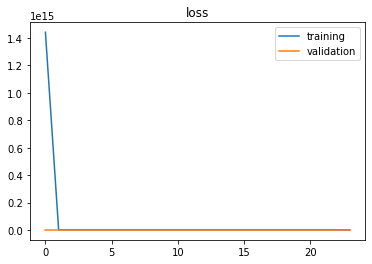

In [89]:
print(f' Starting CV with: CV = {cv}, shuffle = {shuffle}, random_state = {random_state} \n and model parameters: epochs = {epochs}, batch_size =\
 {batch_size}, max_time = {max_time}, mask_value = {mask_value}')

rmse_train = []
r2_train = []
mae_train = []

rmse_test = []
r2_test = []
mae_test = []

train_all = []
test_all = []

file = 'RUL_SA_prelim_results_cmapss_1st_linear.csv'
columns = ['fold', 'rmse_train', 'mae_train', 'r2_train', 'rmse_test', 'mae_test', 'r2_test']
results = pd.DataFrame(columns=columns)

fold_count = 0
      
start = time.time()

for train_units, test_units in kf.split(train_x_orig.unit_number.unique()):
    
    fold_count+= 1
    print(f'Fold: {fold_count}')
    tf.random.set_seed(fold_count)
    
#     print(len(train_units))
#     print(len(test_units))
#     print(train_units)
#     print(test_units)
    
    
    
    # Selecting data
    train_index = train_x_orig[train_x_orig.unit_number.isin(train_units)].index
    test_index = train_x_orig[train_x_orig.unit_number.isin(test_units)].index # careful this was wrongly test_x_orig. It should be train_x_orig

    X_train = train_x_orig.iloc[train_index]
    X_test_or = train_x_orig.iloc[test_index] # careful this was wrongly test_x_orig. It should be train_x_orig
    
    X_train.reset_index(drop=True, inplace=True)
    X_test = X_test_or.reset_index(drop=True, inplace=False) # changed for debugging
    
    
    # Truncating test data randomly
    X_test_trunc = []
    test_y = []
    max_cycle = []
    test_index = [] # for debugging purposes
    temp_or_test_cycles = []
    for i in set(X_test.unit_number.unique()):
        np.random.seed(i)
#         print(i)
        temp_df = X_test[X_test.unit_number==i]
        temp_df.reset_index(drop=True, inplace=True) # for debugging purposes
        length = temp_df.shape[0]
        temp_or_test_cycles.append(length)
        level = np.random.choice(np.arange(5, 96), 1)[0]  
        r = np.int(length*(1-level/100))
        test_index.append(X_test_or[X_test_or.unit_number==i].index.tolist()[:r+1])
        temp_df = temp_df.truncate(after=r)
        max_cycle.append(temp_df.shape[0])
        X_test_trunc.append(temp_df)
#         if max_cycle[-1] <= length/2:
#             test_y.append(130) # value taken from Heimes et al. (2008)

#         else:
#             p = (0 - 130) / (length - length/2)
#             rul = p * max_cycle[-1] - p * length
#             test_y.append(rul)
    test_index = [item for sublist in test_index for item in sublist]
#     print('\n')
#     print(len(test_index))
#     print(test_index)
    X_test_trunc = pd.concat(X_test_trunc)
    X_test_trunc.reset_index(drop=True, inplace=True)
#     print(X_test_trunc.shape)
#     test_y_rul = np.array(test_y) # commented for debugging
#     test_y_rul = test_y_rul.reshape(test_y_rul.shape[0], 1) 
#     test_y = test_y_rul # (comment out when not using event)
#     test_y_event = np.repeat(1, test_y_rul.shape[0]).reshape(test_y_rul.shape[0], 1) # (uncomment when adding event)
#     test_y = np.concatenate([test_y_rul, test_y_event], axis=1) # (uncomment when adding event)
   
    # Pre-processing data
    scaler=pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())])

    train = X_train.copy()
    train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)
    
    test = X_test_trunc.copy()
    test = np.concatenate([test[['unit_number', 'time']], scaler.transform(test[feature_cols])], axis=1)
    
    
    # Preparing data for the RNN (numpy arrays)
    train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
                                  is_test=False, mask_value=mask_value, original_data=None, label='nonlinear')
    

    test_x, test_y = build_data(units=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time,
                       is_test=False, mask_value=mask_value, original_data=X_test_or, label='nonlinear') 
#     print(test_x.shape)
     
    # initialization
    tte_mean_train = np.nanmean(train_y)#[:, 0]) # (uncomment when adding event)
    mean_u = 1.0 #np.nanmean(train_y[:, 1]) # (uncomment when adding event)

    # Initialization value for alpha-bias
#     init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
#     init_alpha = init_alpha / mean_u
#     # print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)
    init_alpha = None

    print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)
    
    # training
    model, history = network(train_x, train_y, test_x, test_y, mask_value, epochs, batch_size, init_alpha)
    
    plt.plot(history.history['loss'],    label='training')
    plt.plot(history.history['val_loss'],label='validation')
    plt.title('loss')
    plt.legend()
    
    # predicting the rul on the train fold
    train_predict = model.predict(train_x)
    train_predict = np.resize(train_predict, (train_x.shape[0], 1)) # changed this to 1 from 2
    train_result = np.concatenate((train_y, train_predict), axis=1)
    train_results_df = pd.DataFrame(train_result, columns=['T', 'predicted_mu']) # (add 'E' for event)
    train_results_df['unit_number'] = train_x_orig.iloc[train_index]['unit_number'].to_numpy()
#     train_results_df['unit_number'] += 1
    train_results_df['time'] = train_x_orig.iloc[train_index]['time'].to_numpy()
#     train_results_df['time'] += 1
    
#     train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
#     train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
#     train_results_df['predicted_mode'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

    
    # predicting the rul on the test fold
    test_predict = model.predict(test_x)
    test_predict = np.resize(test_predict, (test_x.shape[0], 1)) # changed this to 1 from 2
    test_result = np.concatenate((test_y, test_predict), axis=1)
    test_results_df = pd.DataFrame(test_result, columns=['T',  'predicted_mu']) # (add 'E' for event)
#     print(test_results_df.shape)
    test_results_df['unit_number'] = train_x_orig.iloc[test_index]['unit_number'].to_numpy() # Note the train_x_orig
    test_results_df['time'] = train_x_orig.iloc[test_index]['time'].to_numpy()
    
#     test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
#     test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
#     test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

    train_all.append(train_results_df)
    test_all.append(test_results_df)
    
    # performance evaluation
    # train:
    rmse_train.append(np.sqrt(mean_squared_error(train_results_df['predicted_mu'], train_results_df['T'])))
    mae_train.append((mean_absolute_error(train_results_df['predicted_mu'], train_results_df['T'])))
    r2_train.append(r2_score(train_results_df['predicted_mu'], train_results_df['T']))
    
    # test:
    rmse_test.append(np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T'])))
    mae_test.append((mean_absolute_error(test_results_df['predicted_mu'], test_results_df['T'])))
    r2_test.append(r2_score(test_results_df['predicted_mu'], test_results_df['T']))
    
    
    # registering results
    results['fold'] = [fold_count]
    results['rmse_train'] = [rmse_train[-1]]
    results['mae_train'] = [mae_train[-1]]
    results['r2_train'] = [r2_train[-1]]
    results['rmse_test'] = [rmse_test[-1]]
    results['mae_test'] = [mae_test[-1]]
    results['r2_test'] = [r2_test[-1]]   
    
    print(results)
    
    if os.path.isfile(file):
        results.to_csv('./' + file, mode='a', index=False, header=False)
    else:
        results.to_csv('./' + file, mode='w', index=False, header=True)
    
#     k.clear_session()
#     del model
    
    break

end = time.time()
print(f'Elapsed time: {(end - start)/60} minutes')

In [156]:
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (18597, 100, 17) train_y (18597, 1) test_x (10, 100, 17) test_y (10, 1)


In [122]:
max_cycle

[113, 90, 142, 63, 141, 64, 133, 71, 112, 105]

In [124]:
np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T']))

58.367189604662535

In [84]:
np.sqrt(mean_squared_error(train_results_df['predicted_mu'], train_results_df['T']))

30.85956538048739

Testing on dedicated test set

In [97]:
test_or = test_x_orig.copy()
test_or = np.concatenate([test_or[['unit_number', 'time']], scaler.transform(test_or[feature_cols])], axis=1)


# Preparing data for the RNN (numpy arrays)
test_or, _ = build_data(units=test_or[:, 0], time=test_or[:, 1], x=test_or[:, 2:], max_time=max_time,
                   is_test=True, mask_value=mask_value, original_data=test_x_orig)


100%|██████████| 100/100 [00:00<00:00, 1263.45it/s]


In [98]:
test_predict_or = model.predict(test_or_fin)
test_predict_or = np.resize(test_predict_or, (test_or.shape[0], 2))
test_result_or = np.concatenate((test_y_orig, test_predict_or), axis=1)
test_results_df_or = pd.DataFrame(test_result_or, columns=['T', 'alpha', 'beta'])
test_results_df_or['unit_number'] = np.arange(1, test_results_df_or.shape[0]+1)

test_results_df_or['predicted_mu'] = test_results_df_or[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)

In [100]:
test_results_df_or

,T,alpha,beta,unit_number,predicted_mu
0,112.0,157.594910,156.026337,1,1.570183e+02
1,98.0,120.080917,149.796371,2,1.196235e+02
2,69.0,159.316910,172.385757,3,1.587887e+02
3,82.0,117.000237,153.065094,4,1.165639e+02
4,91.0,155.157135,89.270233,5,1.541730e+02
...,...,...,...,...,...
95,137.0,0.036266,0.051253,96,2.026082e+16
96,82.0,0.039746,25.433374,97,3.890265e-02
97,59.0,108.909950,161.331726,98,1.085244e+02
98,117.0,93.512886,71.629967,99,9.277713e+01


In [101]:
np.sqrt(mean_squared_error(test_results_df_or['predicted_mu'], test_results_df_or['T']))

4.029431420928106e+30

### Plotting

In [90]:
def plot_weibull_predictions(results_df, unit):

#     fig, axarr = plt.subplots(3, figsize=(30,20))
    
    plt.figure(figsize=(30,10))

    t=np.arange(0,400)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

#     ax=axarr[0]
    
#     median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
#     mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
#     mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
    x = results_df['time']
    
    plt.plot(x, results_df['T'], label='survival_time', color='black')

#     ax.plot(x, median_predictions, label='median_prediction')
    plt.plot(x, results_df['predicted_mu'], label='mean_prediction')
#     ax.plot(x, mode_predictions, label='mode_prediction')
#     ax.set_title('MAP prediction Vs. true')
    

    plt.legend()
    
#     ax=axarr[1]
#     sns.distplot(results_df['T'] - mode_predictions, ax=ax)
#     ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[2]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(unit)
    plt.show()

Plotting validation

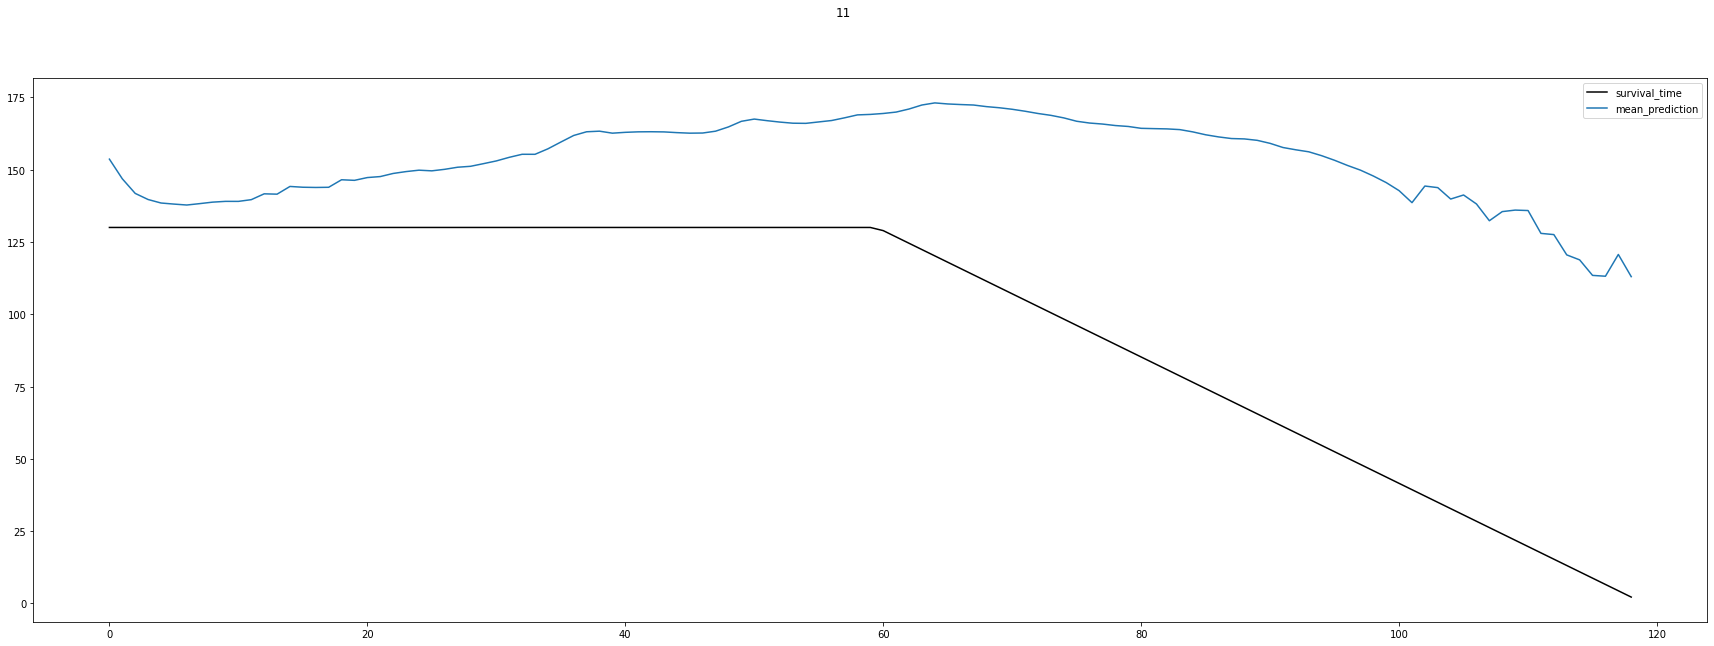

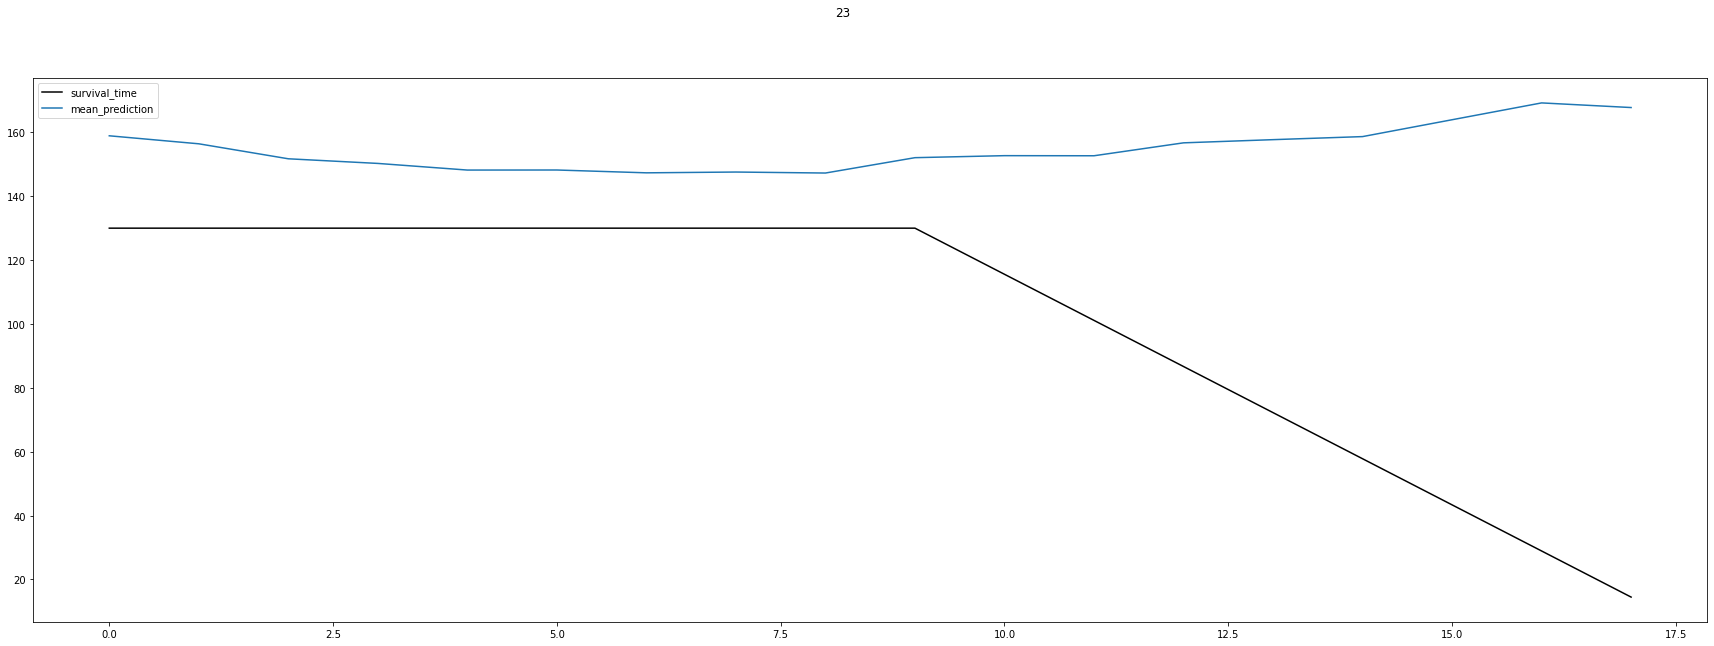

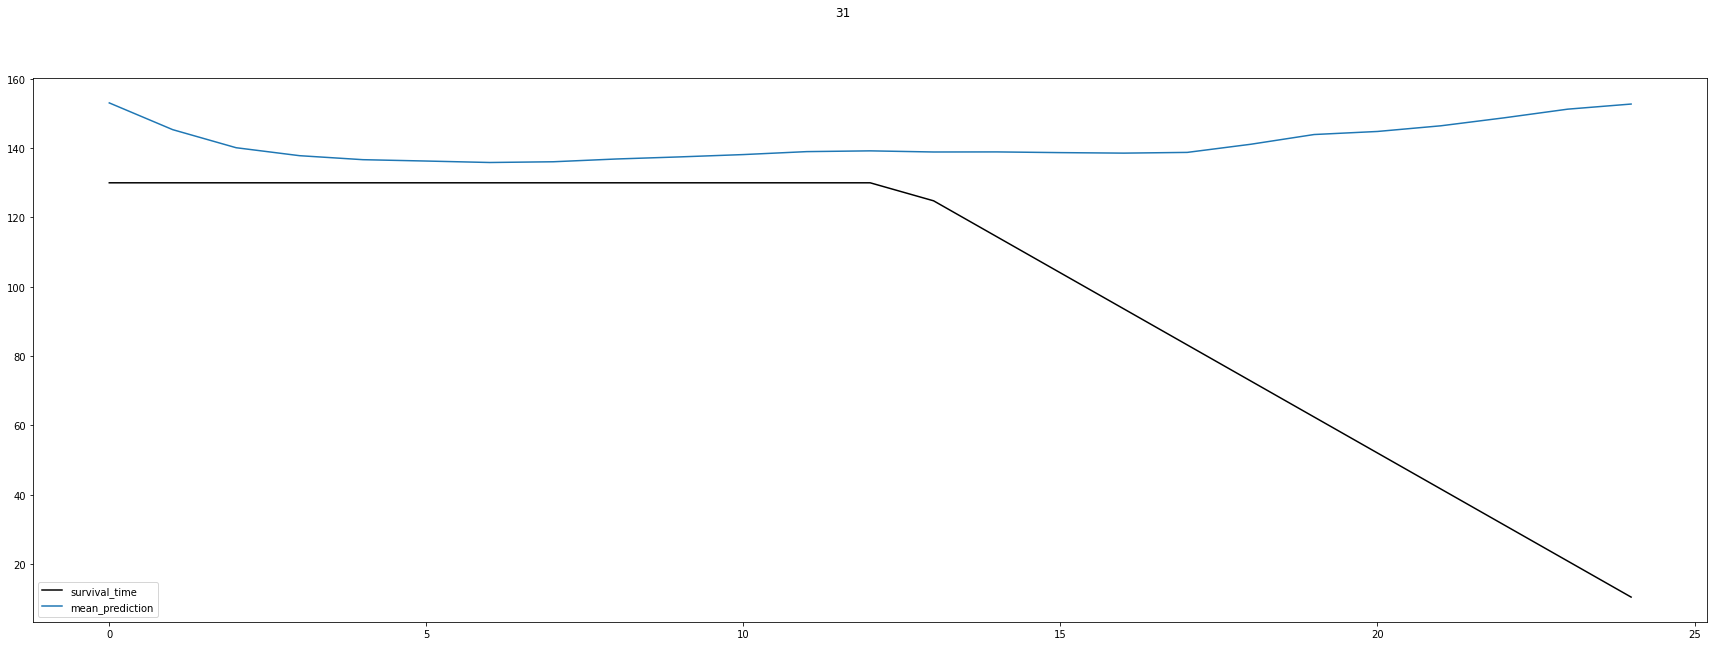

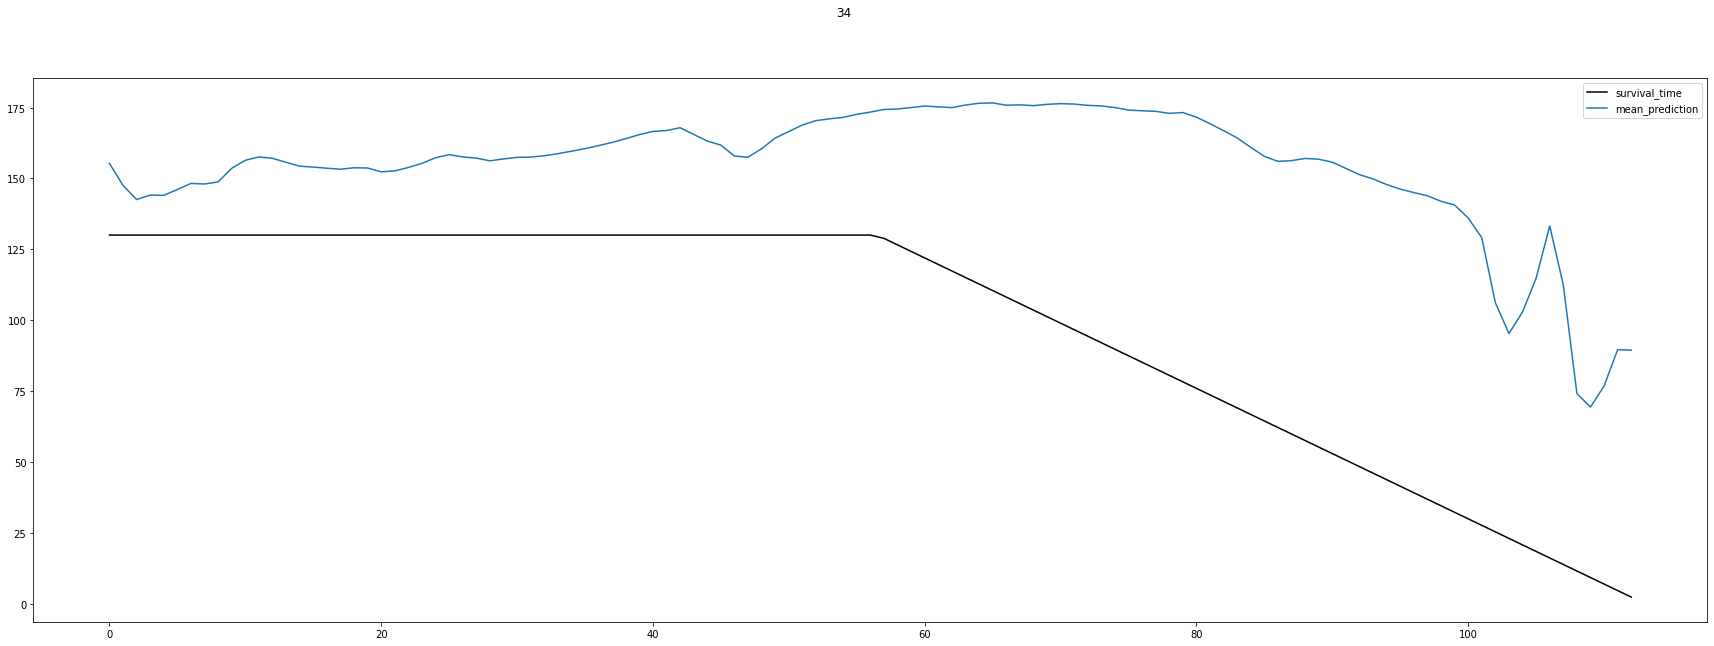

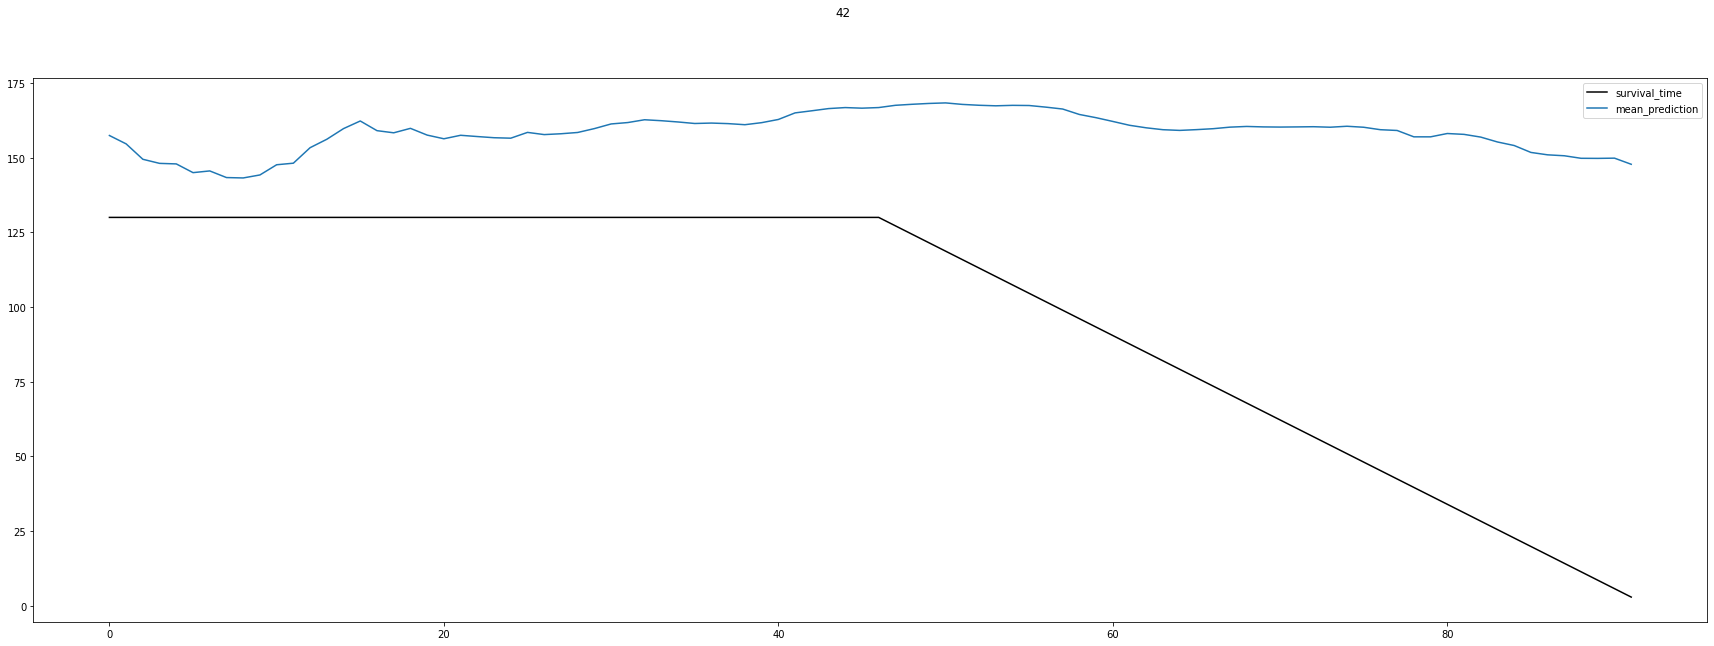

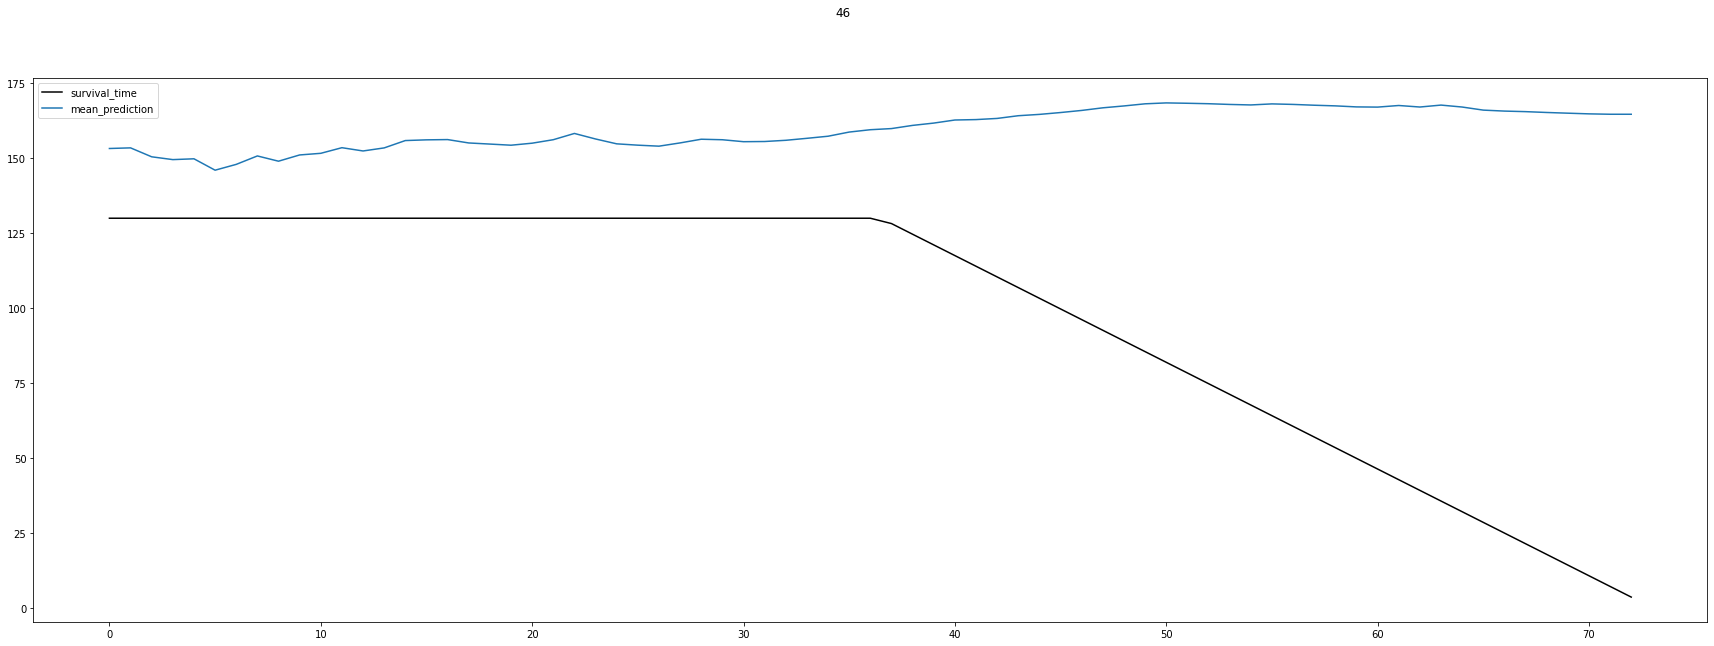

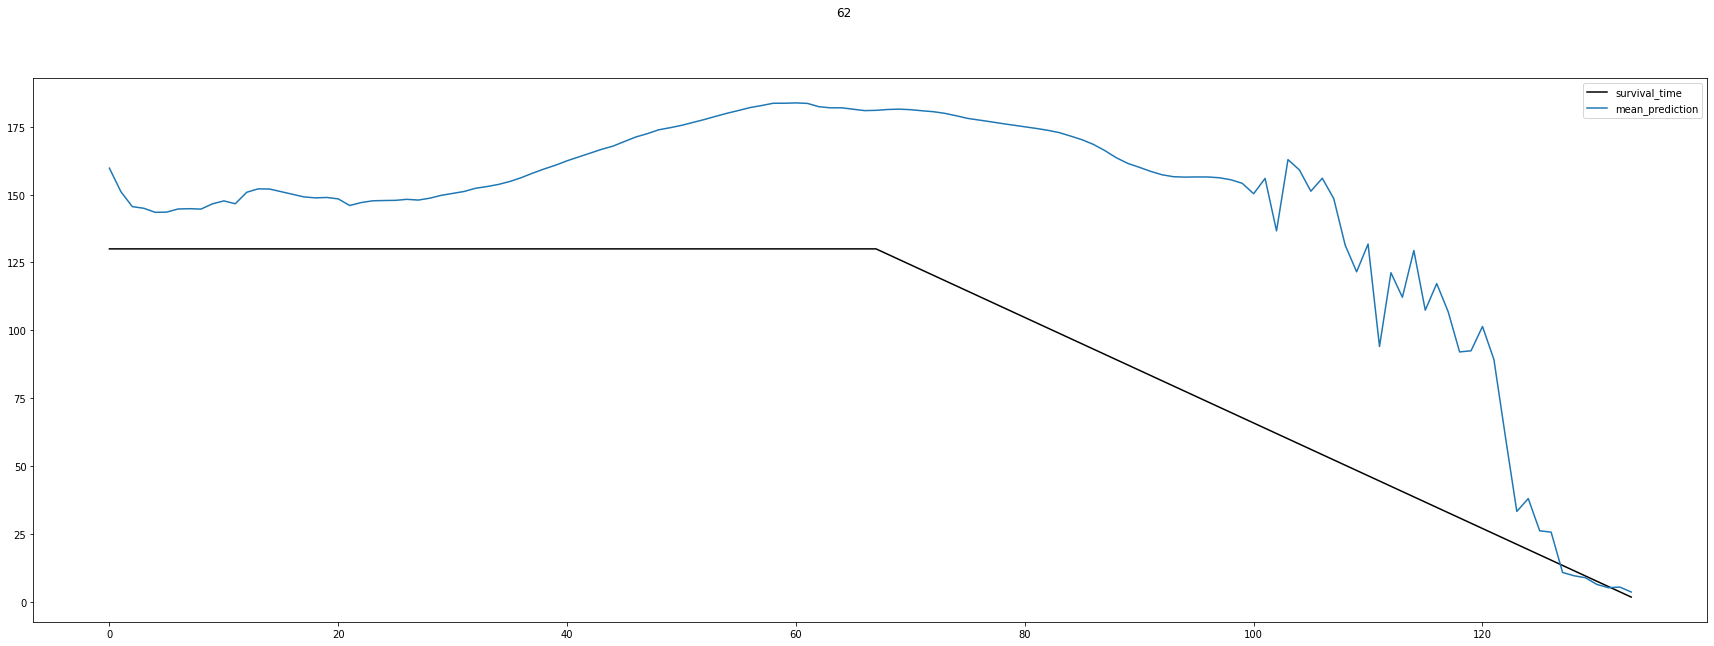

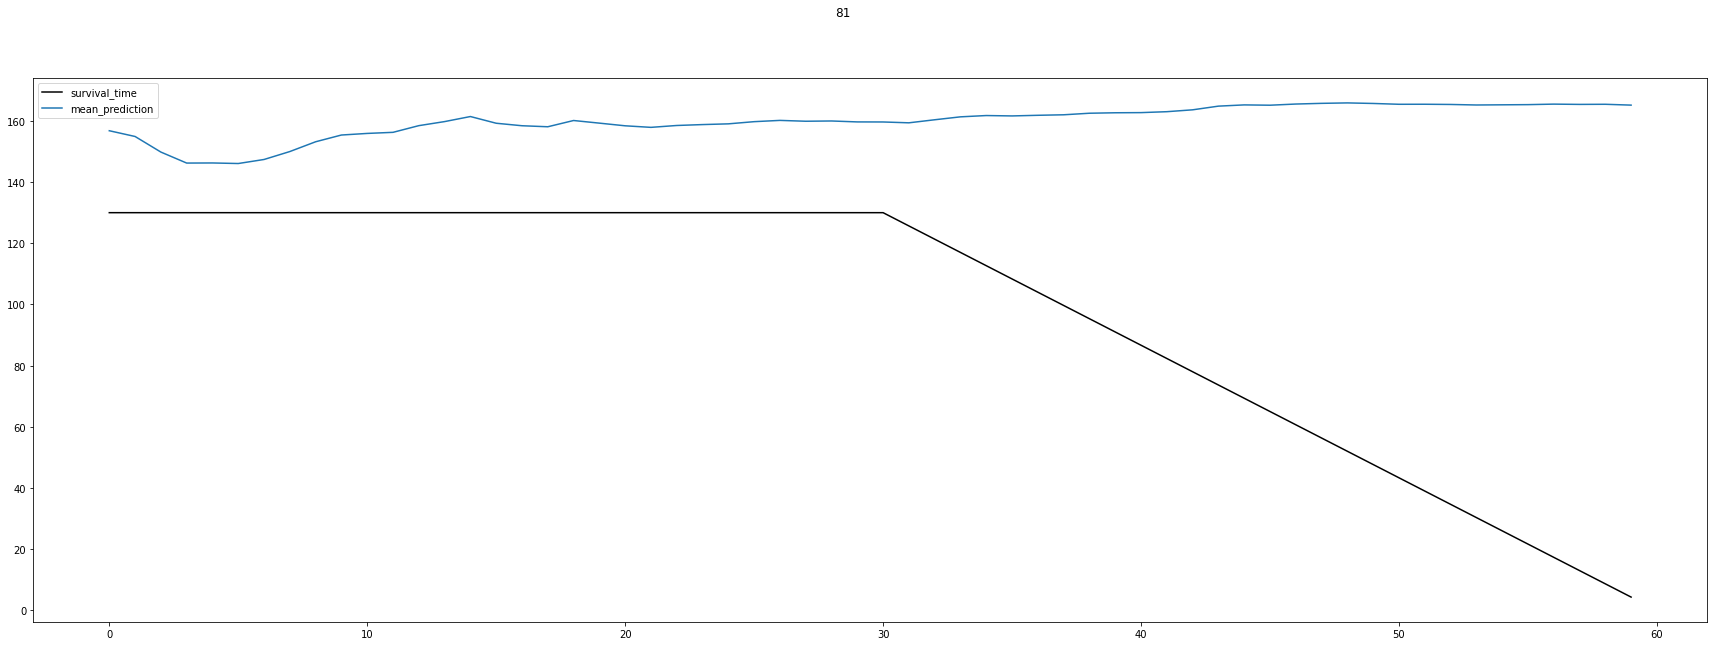

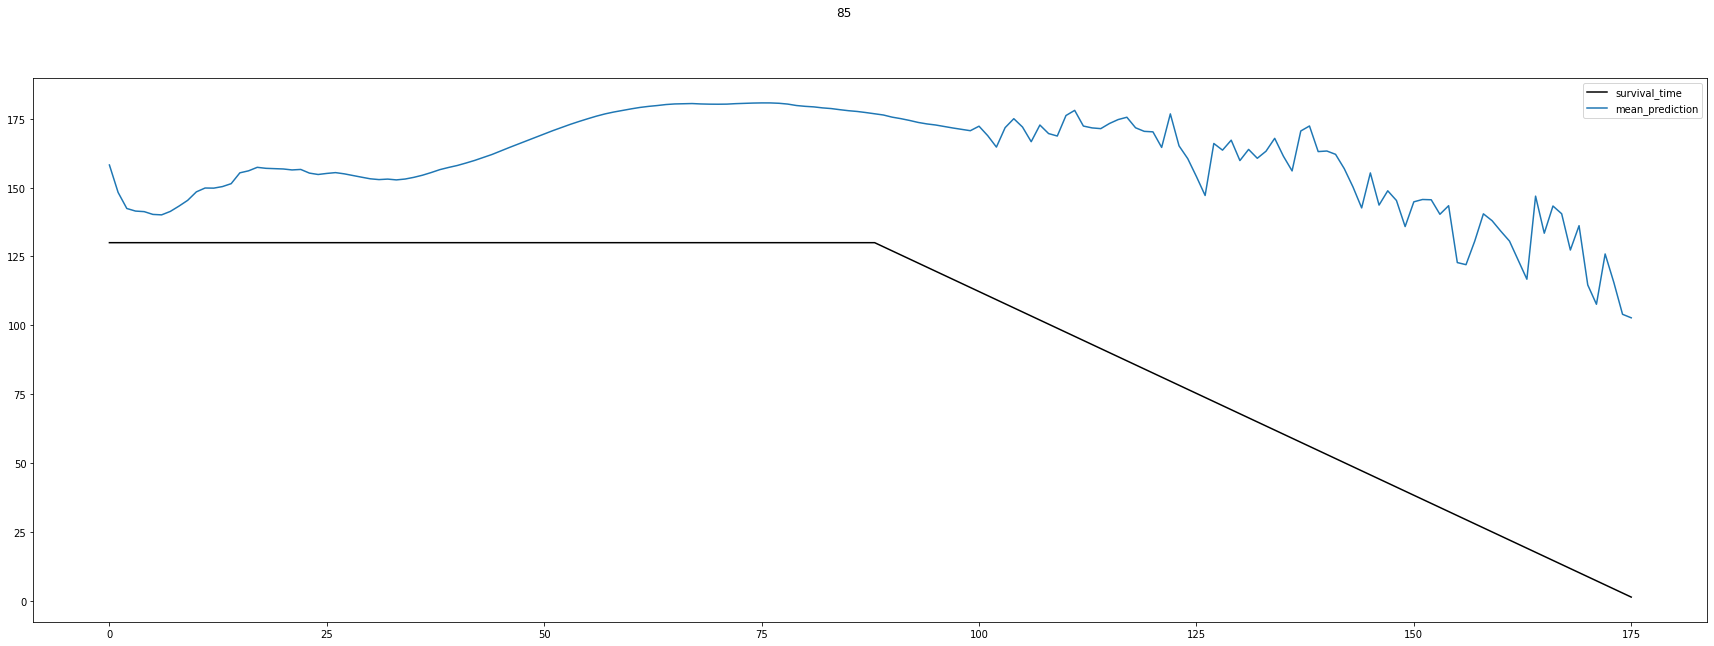

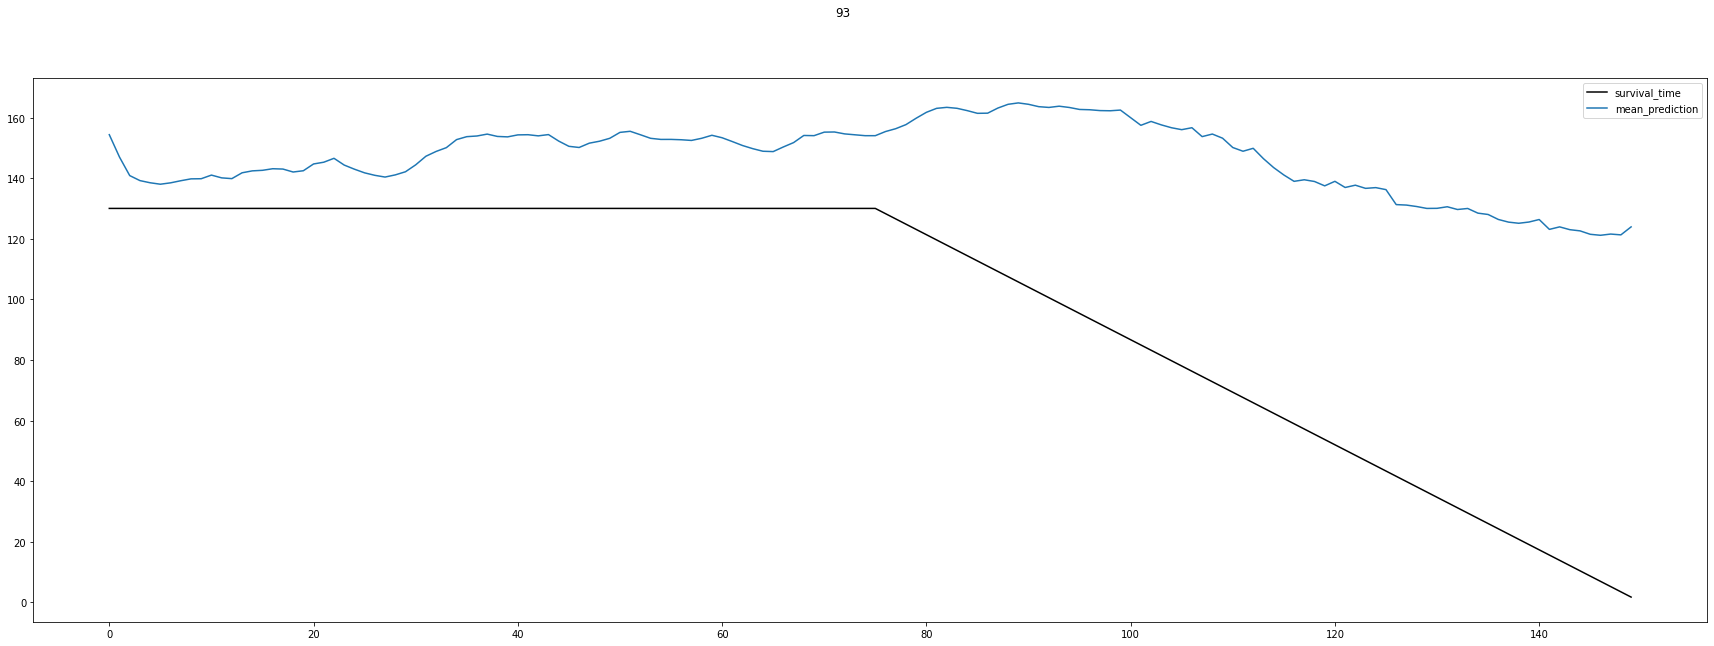

In [91]:
for unit_number, grp in test_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp, unit_number)

Plotting training (takes time...press stop if you want)

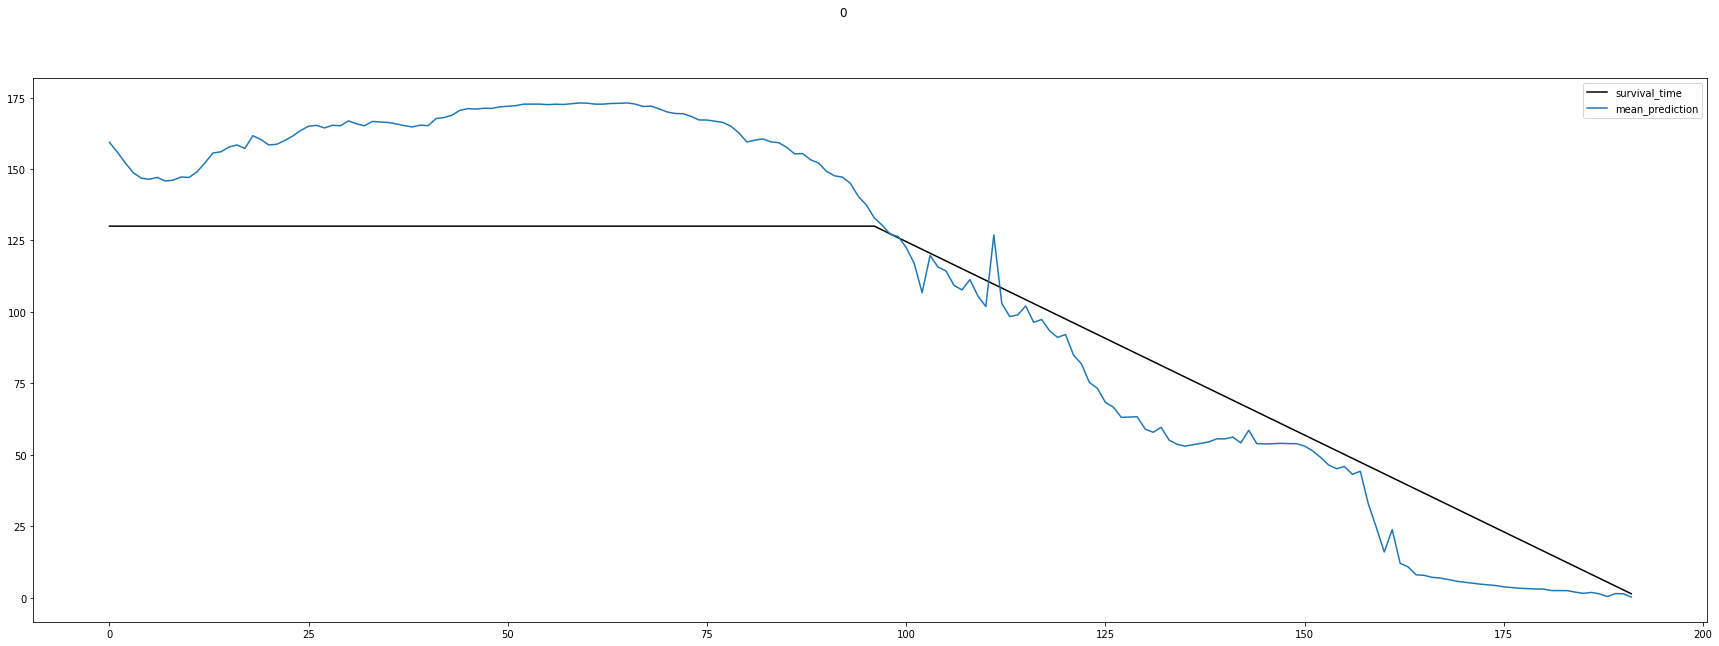

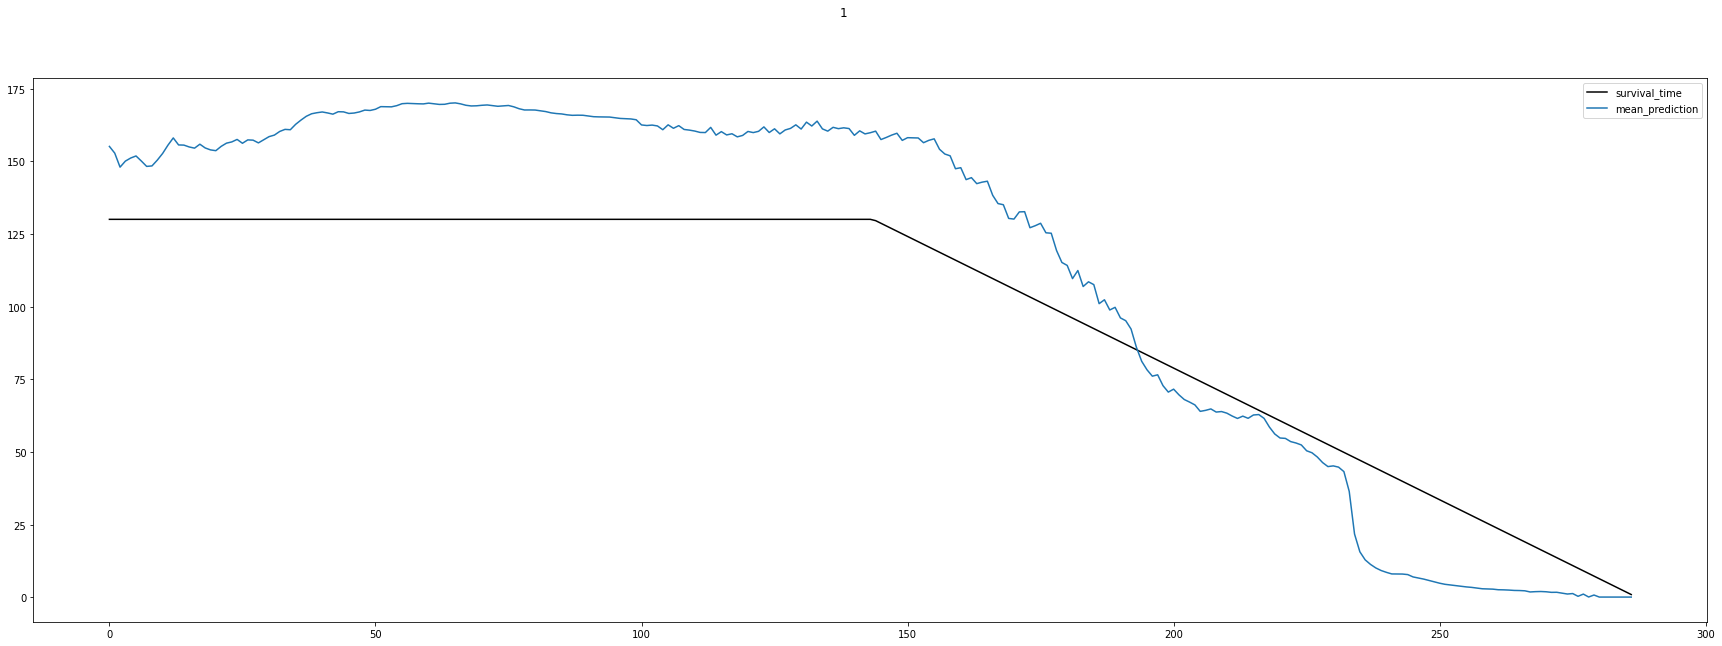

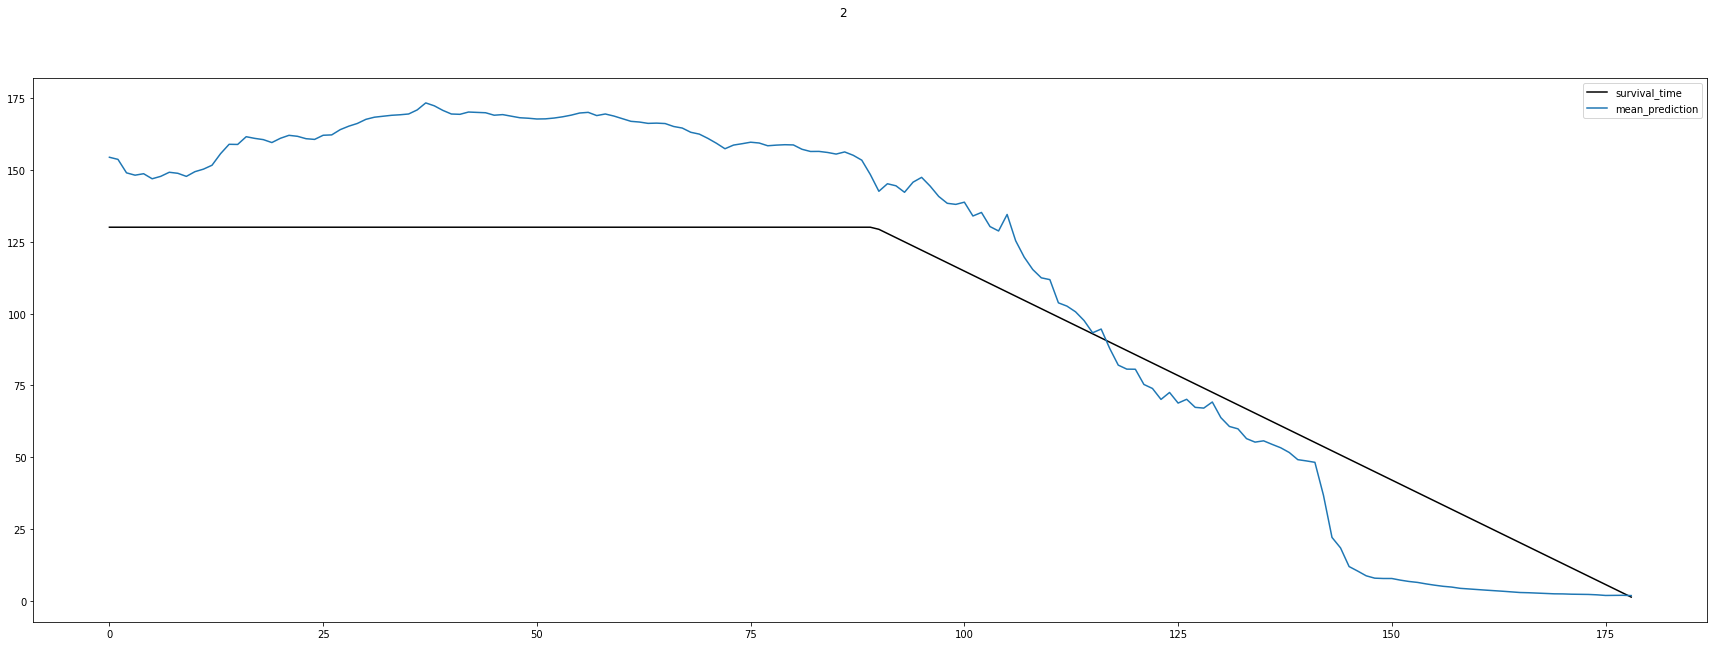

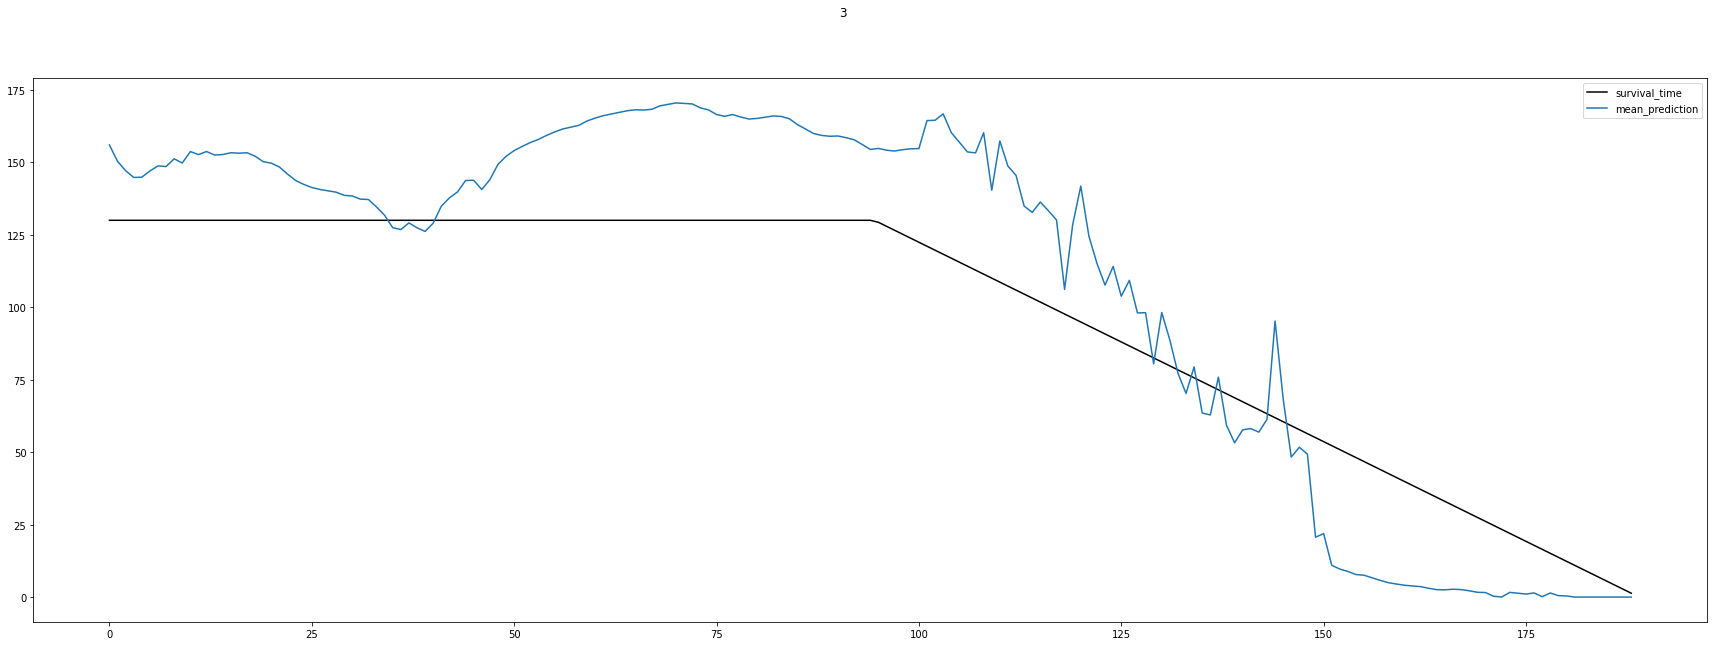

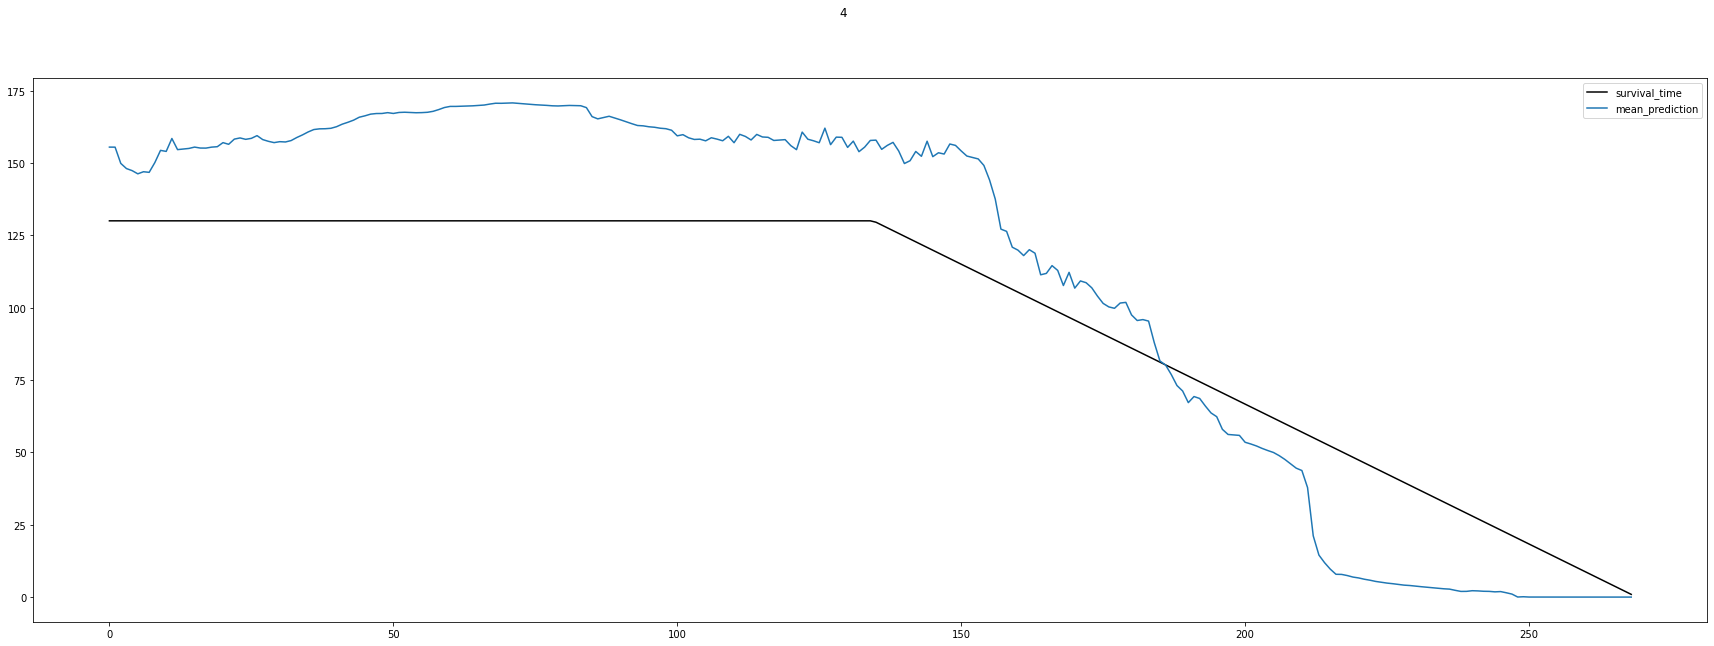

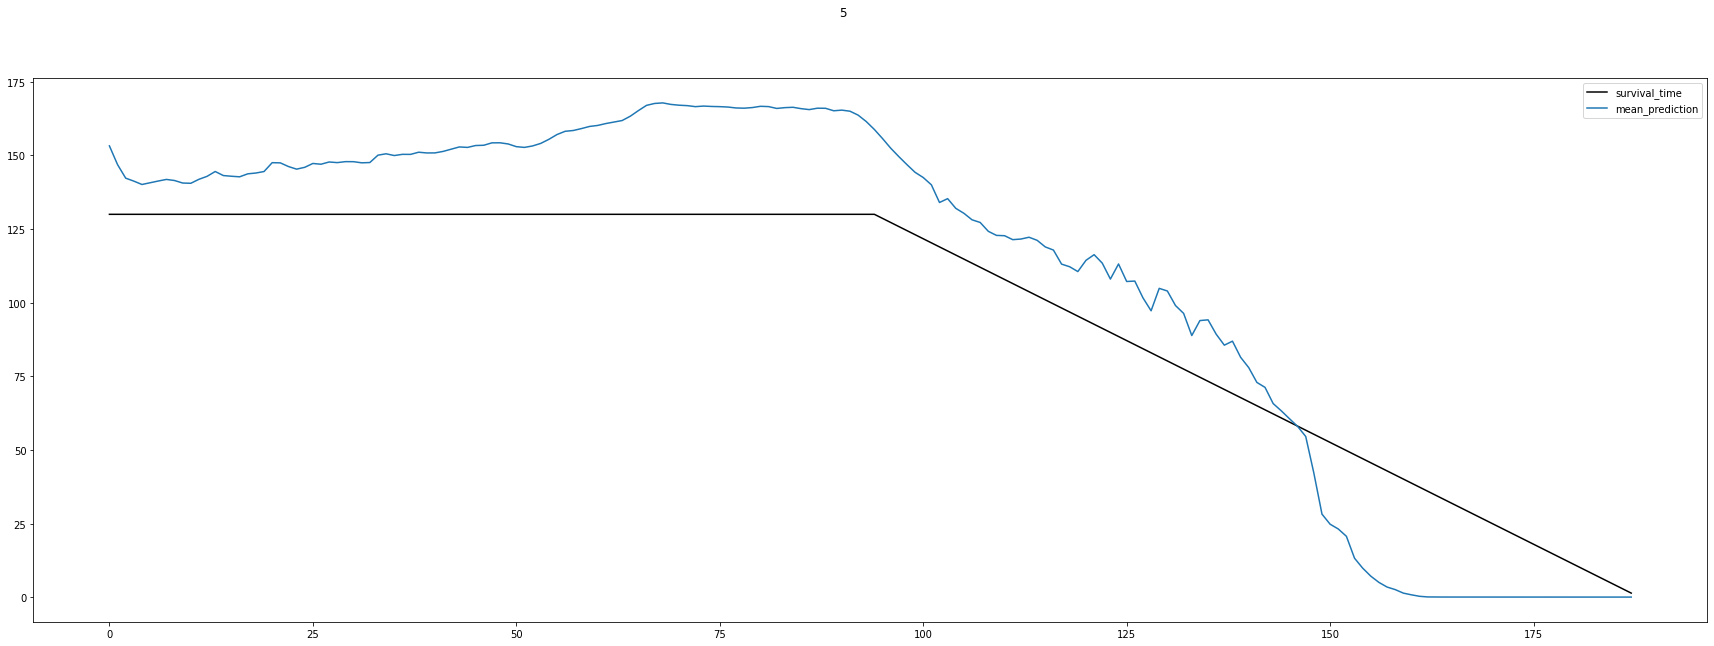

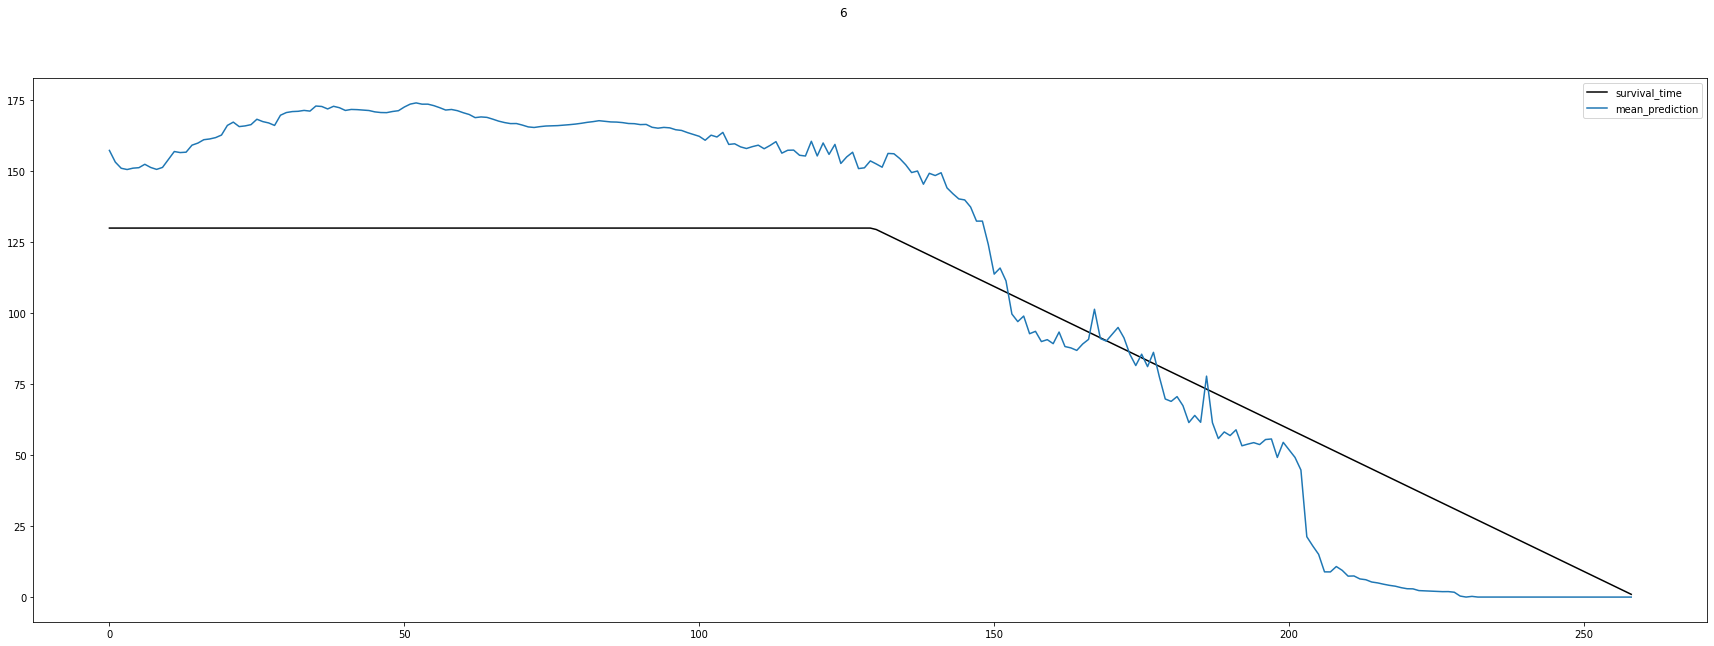

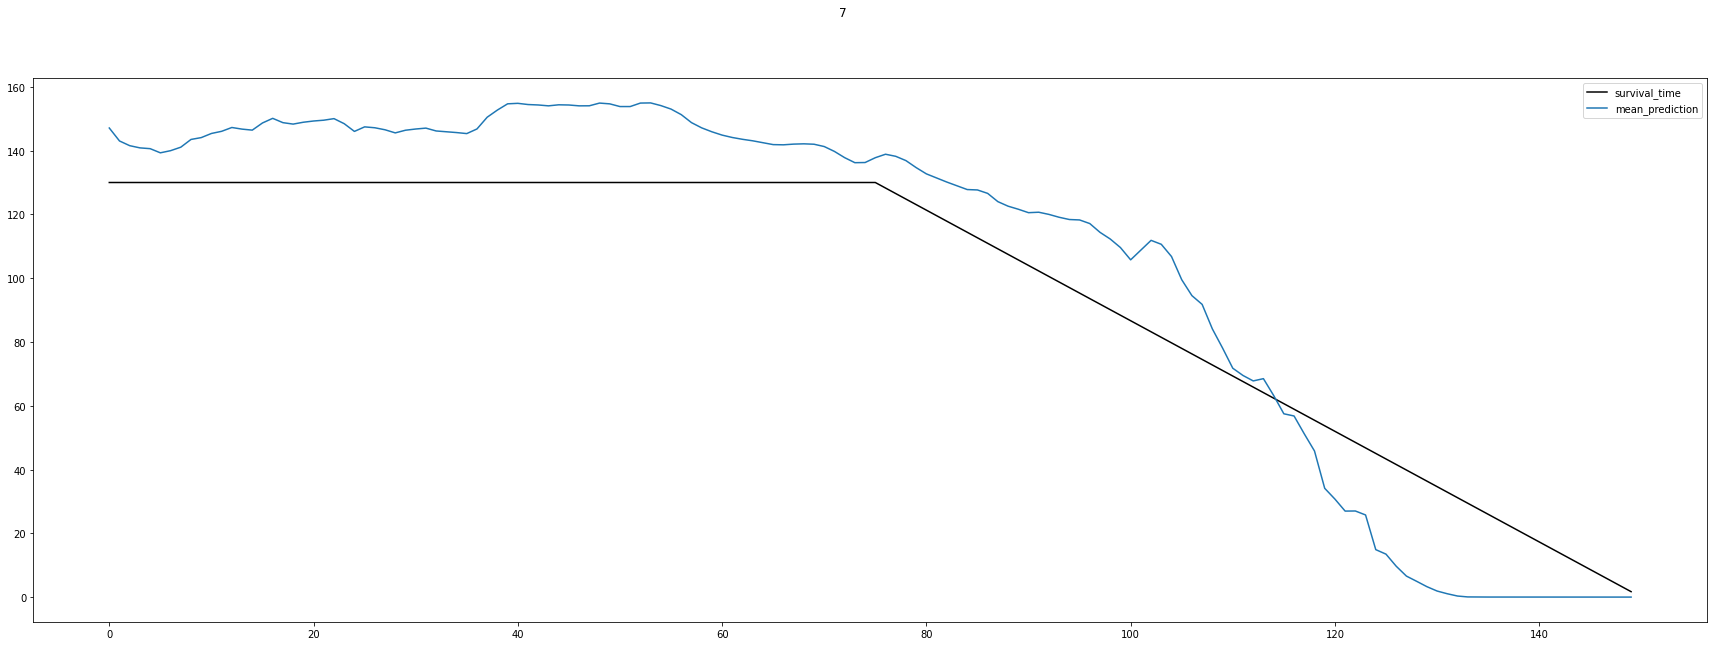

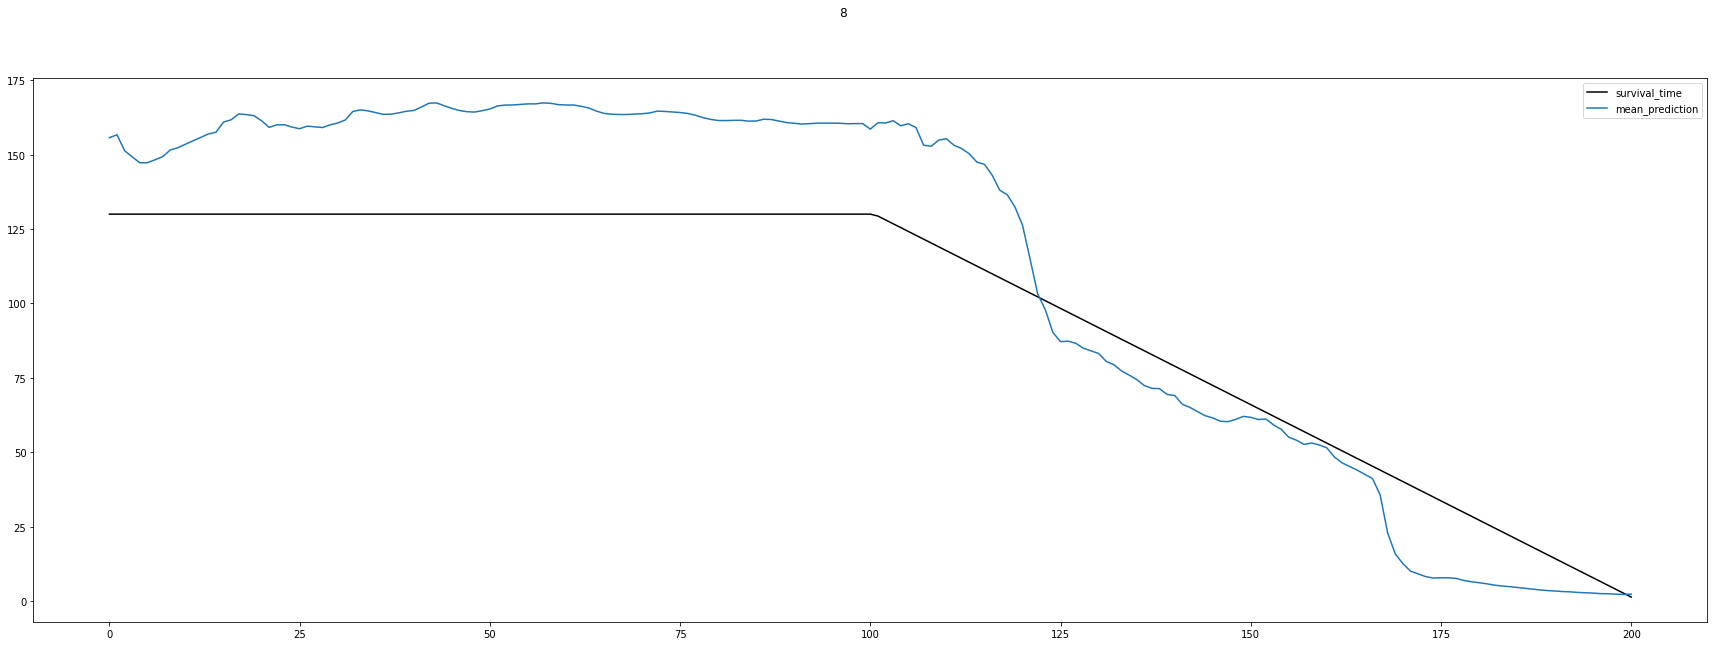

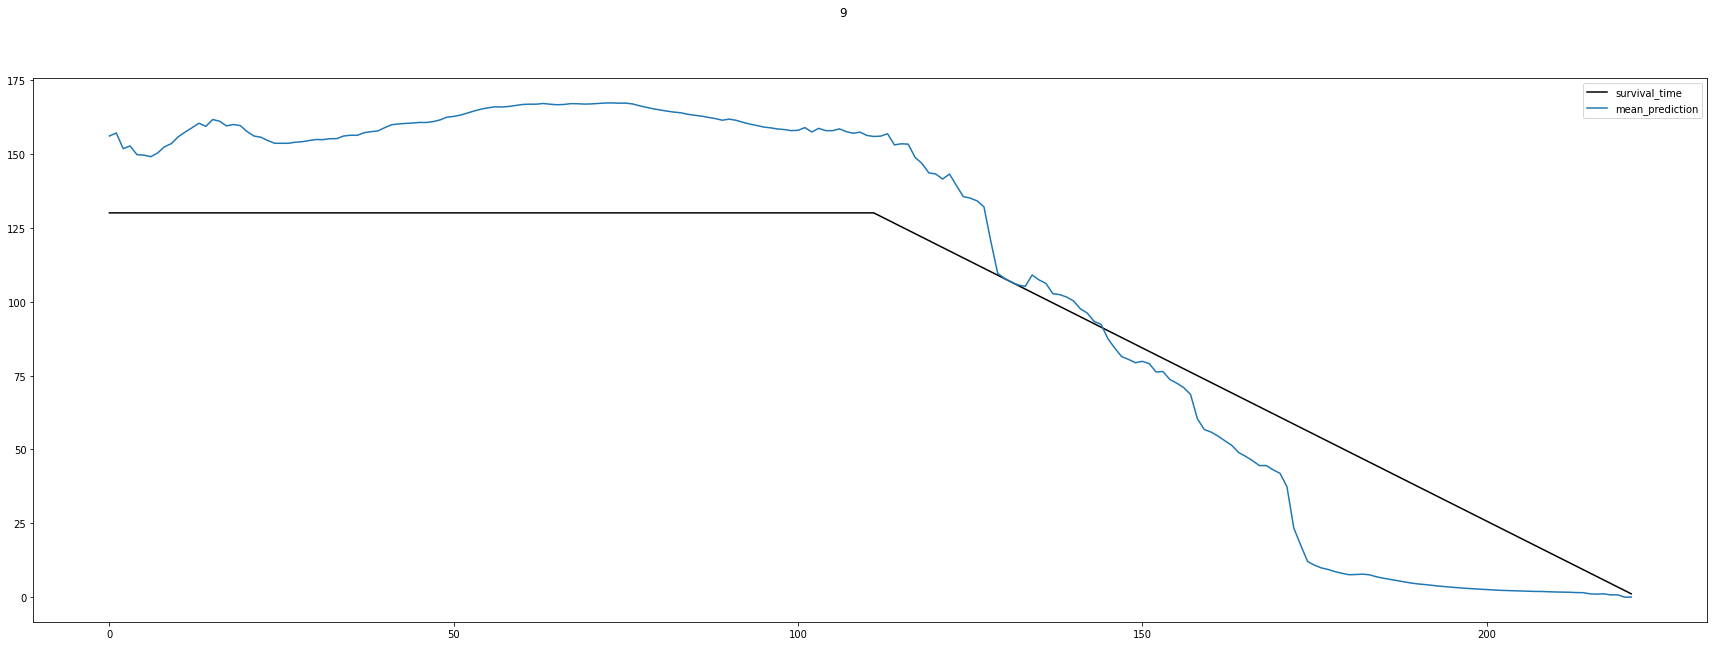

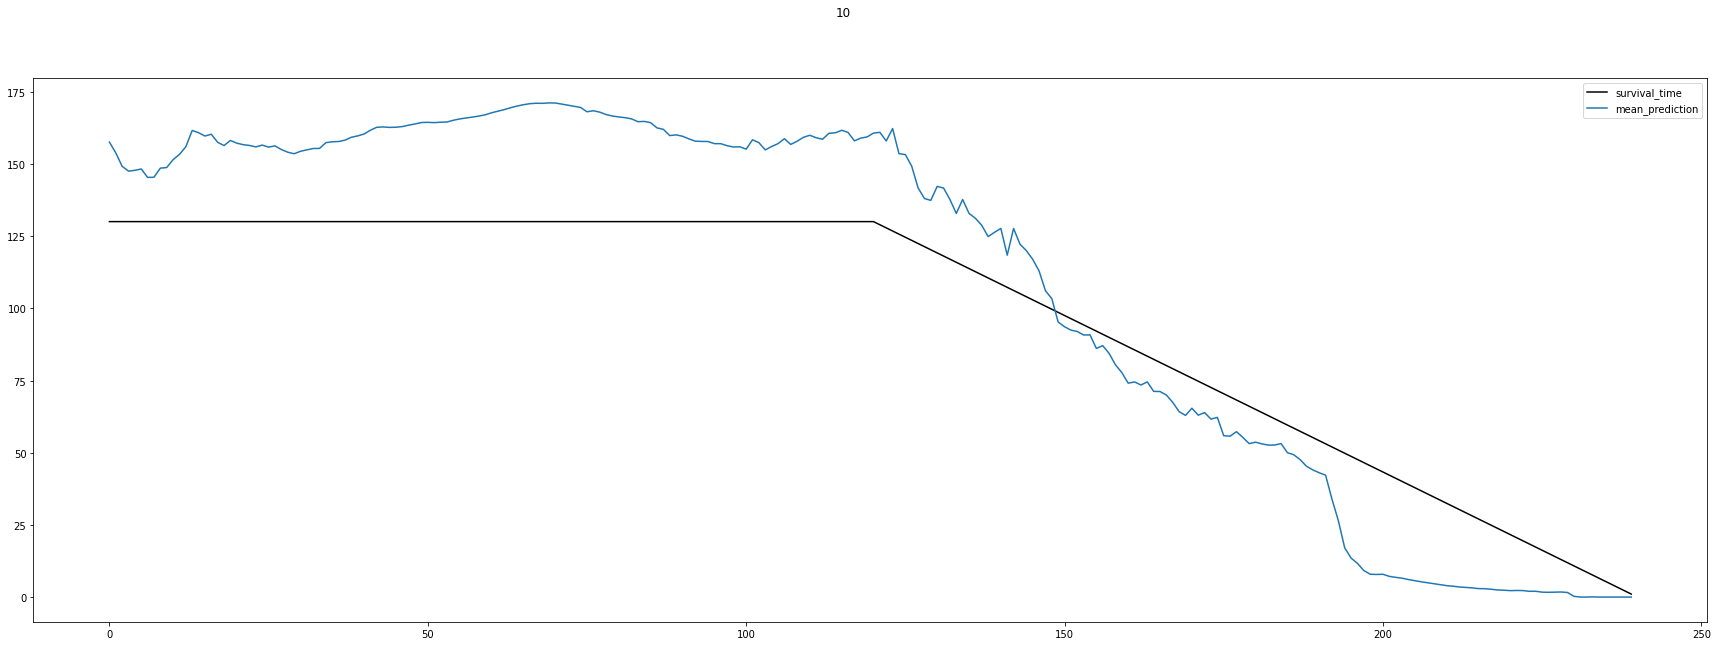

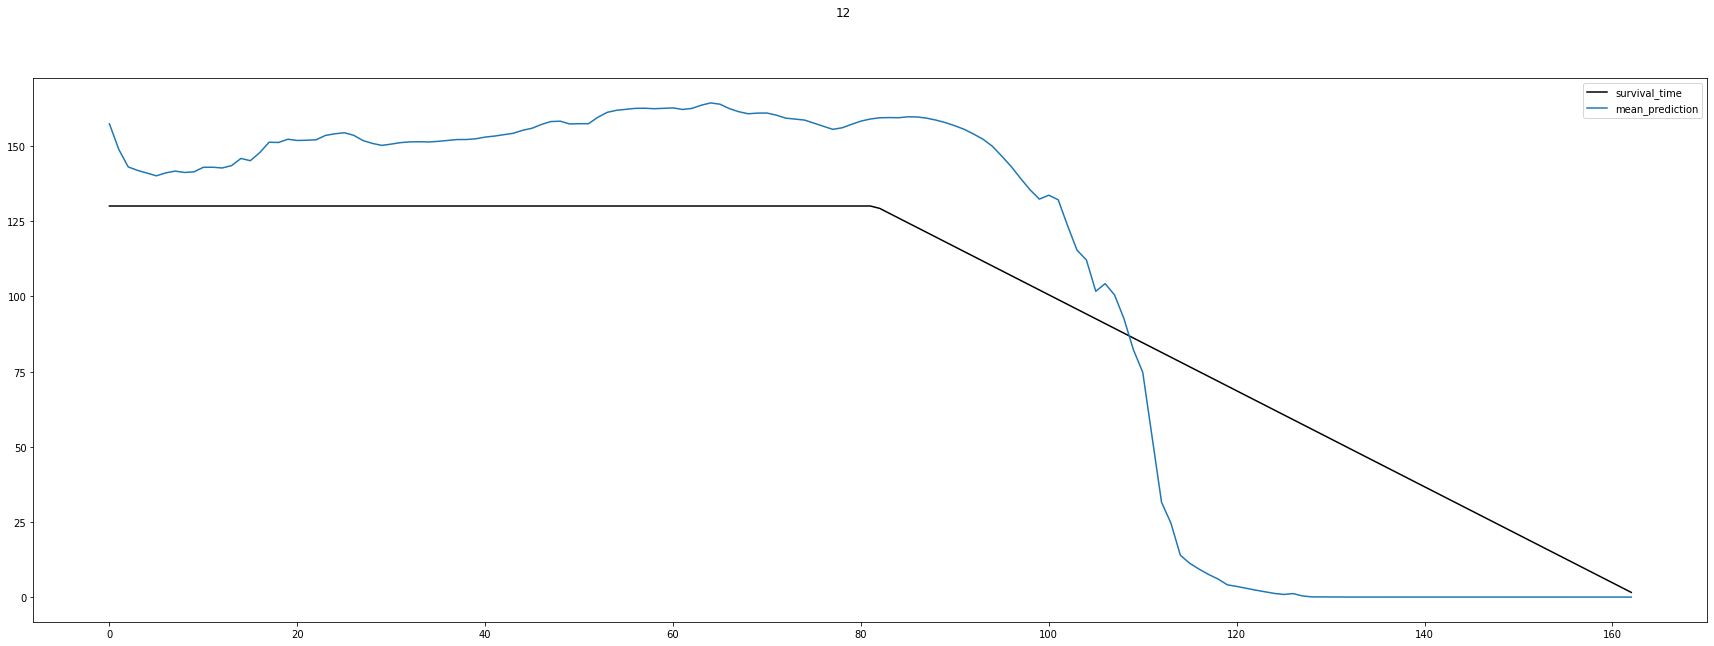

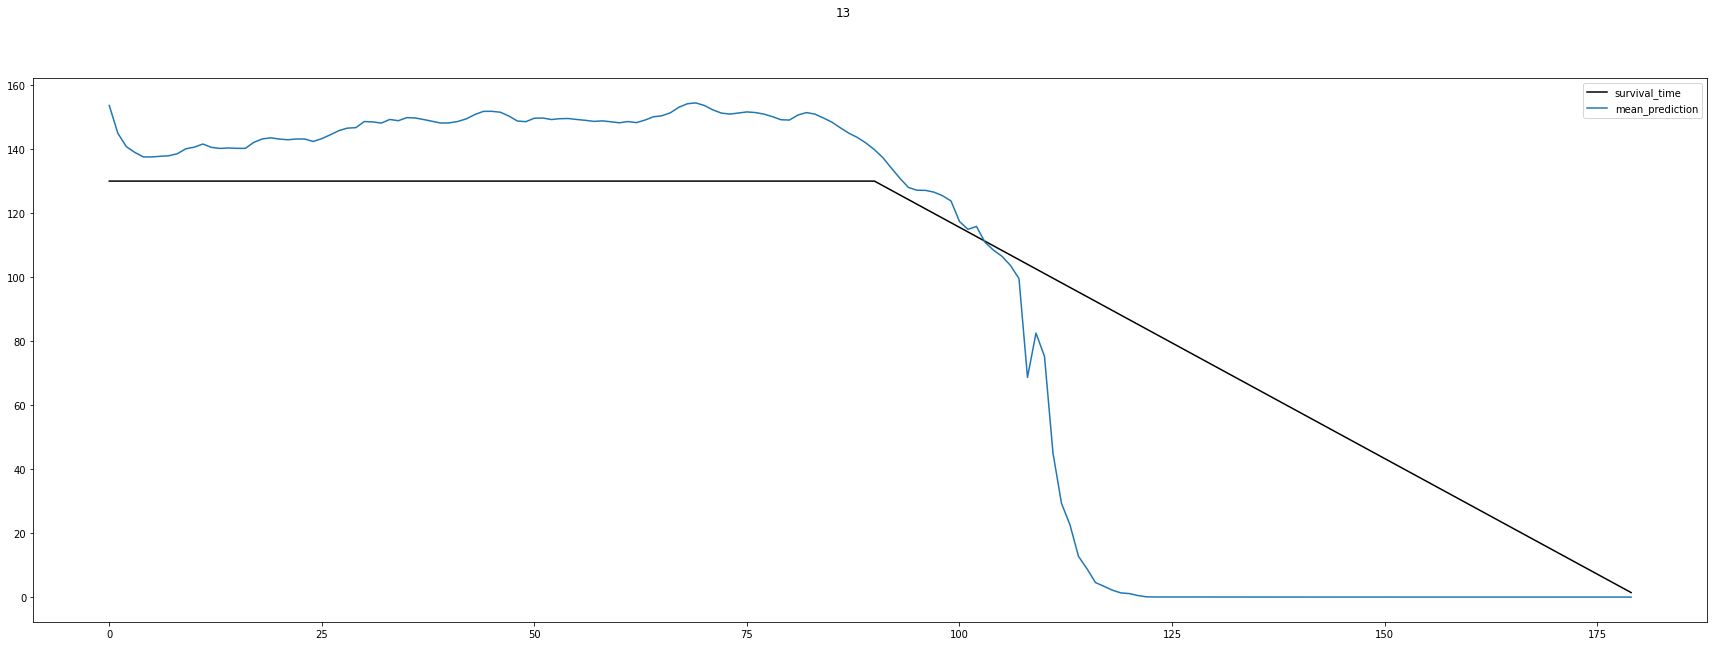

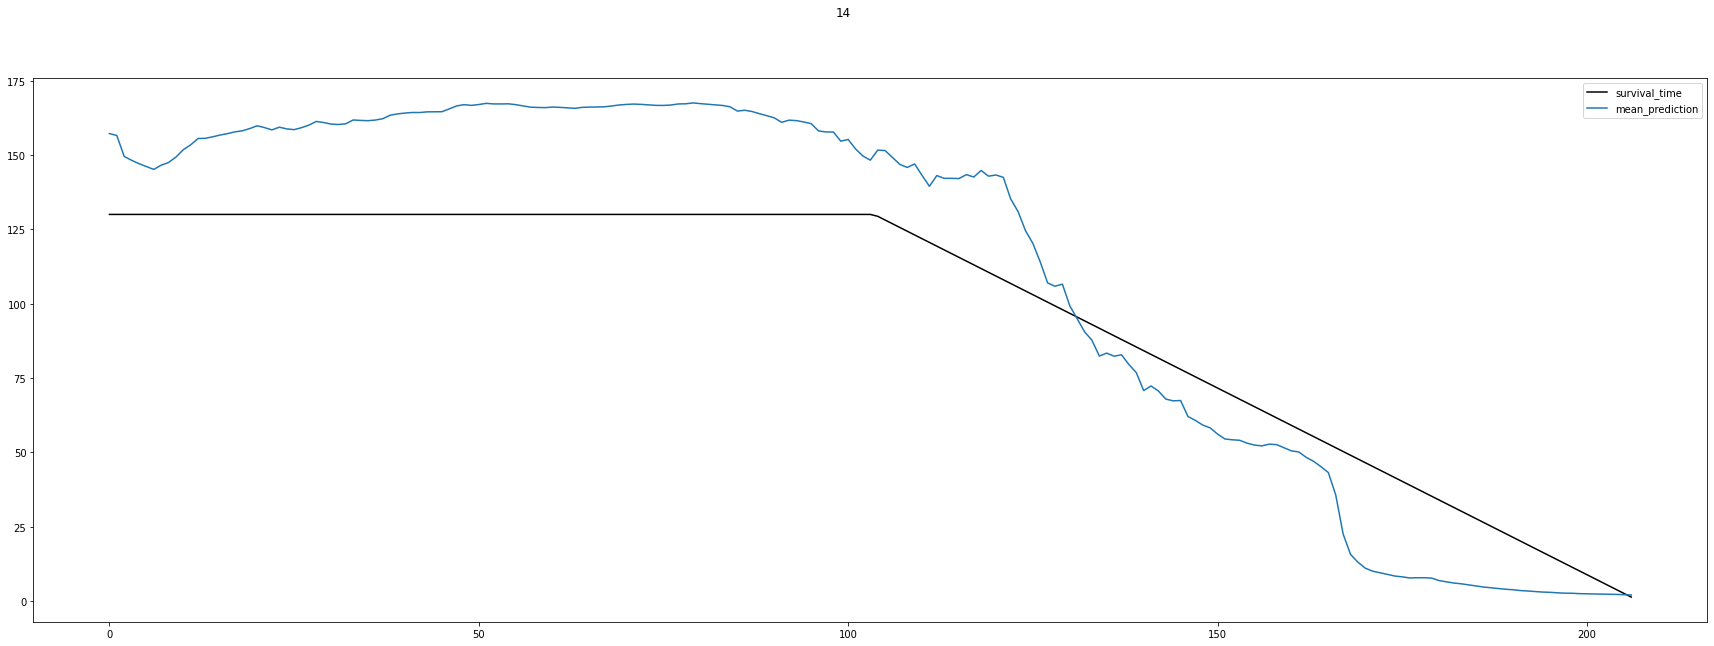

KeyboardInterrupt: 

In [102]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp, unit_number)

***

Ignore...

In [54]:
# print(f' Starting CV with: CV = {cv}, shuffle = {shuffle}, random_state = {random_state} \n and model parameters: epochs = {epochs}, batch_size =\
#  {batch_size}, max_time = {max_time}, mask_value = {mask_value}')

# rmse_train = []
# r2_train = []
# mae_train = []

# rmse_test = []
# r2_test = []
# mae_test = []

# train_all = []
# test_all = []

# file = 'RUL_SA_prelim_results_cmapss_1st_2.csv'
# columns = ['fold', 'rmse_train', 'mae_train', 'r2_train', 'rmse_test', 'mae_test', 'r2_test']
# results = pd.DataFrame(columns=columns)

# fold_count = 0
      
# start = time.time()

# for train_units, test_units in kf.split(train_x_orig.unit_number.unique()):
    
#     tf.random.set_seed(3)
    
# #     print(train_units)
# #     print(test_units)
    
#     fold_count+= 1
    
#     # Selecting data
#     train_index = train_x_orig[train_x_orig.unit_number.isin(train_units)].index
#     test_index = test_x_orig[test_x_orig.unit_number.isin(test_units)].index

#     X_train = train_x_orig.iloc[train_index]
#     X_test = test_x_orig.iloc[test_index]
    
#     X_train.reset_index(drop=True, inplace=True)
#     X_test.reset_index(drop=True, inplace=True)
    
    
#     # Truncating test data
#     X_test_trunc = []
#     test_y = []
#     max_cycle = []
#     for i in set(X_test.unit_number.unique()):
#         np.random.seed(i)
#         temp_df = X_test[X_test.unit_number==i]
#         temp_df.reset_index(drop=True, inplace=True)
#         length = temp_df.shape[0]
#         level = np.random.choice(np.arange(10, 50), 1)[0]  
#         r = np.int(length*(1-level/100))
#         temp_df = temp_df.truncate(after=r)
#         max_cycle.append(temp_df.shape[0])
#         X_test_trunc.append(temp_df)
#         test_y.append(length-temp_df.shape[0])    
    
#     X_test_trunc = pd.concat(X_test_trunc)
#     X_test_trunc.reset_index(drop=True, inplace=True)
#     test_y_rul = np.array(test_y)
#     test_y_rul = test_y_rul.reshape(test_y_rul.shape[0], 1)
#     test_y_event = np.repeat(1, test_y_rul.shape[0]).reshape(test_y_rul.shape[0], 1)
#     test_y = np.concatenate([test_y_rul, test_y_event], axis=1)
# #     print(X_test_trunc.shape)
    
# #     Y_test = test_y_orig.copy()
# #     Y_test = Y_test.iloc[test_units]
# #     Y_test.reset_index(drop=True, inplace=True)
    
#     # Pre-processing data
#     scaler=pipeline.Pipeline(steps=[
#      ('minmax', MinMaxScaler(feature_range=(-1, 1))),
#      ('remove_constant', VarianceThreshold())])

#     train = X_train.copy()
#     train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)
    
#     test = X_test_trunc.copy()
#     test = np.concatenate([test[['unit_number', 'time']], scaler.transform(test[feature_cols])], axis=1)
    
    
#     # Preparing data for the RNN (numpy arrays)
#     train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
#                                   is_test=False, mask_value=mask_value)

#     test_x, _ = build_data(units=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time,
#                        is_test=True, mask_value=mask_value)
    
   
#     # initialization
#     tte_mean_train = np.nanmean(train_y[:, 0])
#     mean_u = np.nanmean(train_y[:, 1])

#     # Initialization value for alpha-bias
#     init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
#     init_alpha = init_alpha / mean_u
# #     print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)
    
#     # training
#     model, history = network(train_x, train_y, test_x, test_y, mask_value, epochs, batch_size, init_alpha)
    
#     plt.plot(history.history['loss'],    label='training')
#     plt.plot(history.history['val_loss'],label='validation')
#     plt.title('loss')
#     plt.legend()
    
#     # predicting the rul on the train fold
#     train_predict = model.predict(train_x)
#     train_predict = np.resize(train_predict, (train_x.shape[0], 2))
#     train_result = np.concatenate((train_y, train_predict), axis=1)
#     train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])
#     train_results_df['unit_number'] = np.arange(1, train_results_df.shape[0]+1)
    
#     train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
# #     train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
# #     train_results_df['predicted_mode'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

    
#     # predicting the rul on the test fold
#     test_predict = model.predict(test_x)
#     test_predict = np.resize(test_predict, (test_x.shape[0], 2))
#     test_result = np.concatenate((test_y, test_predict), axis=1)
#     test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
#     test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)
    
#     test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
# #     test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
# #     test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

#     train_all.append(train_results_df)
#     test_all.append(test_results_df)
    
#     # performance evaluation
#     # train:
#     rmse_train.append(np.sqrt(mean_squared_error(train_results_df['predicted_mu'], train_results_df['T'])))
#     mae_train.append((mean_absolute_error(train_results_df['predicted_mu'], train_results_df['T'])))
#     r2_train.append(r2_score(train_results_df['predicted_mu'], train_results_df['T']))
    
#     # test:
#     rmse_test.append(np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T'])))
#     print(rmse_test[-1])
#     mae_test.append((mean_absolute_error(test_results_df['predicted_mu'], test_results_df['T'])))
#     r2_test.append(r2_score(test_results_df['predicted_mu'], test_results_df['T']))
    
#     # registering results
#     results['fold'] = [fold_count]
#     results['rmse_train'] = [rmse_train[-1]]
#     results['mae_train'] = [mae_train[-1]]
#     results['r2_train'] = [r2_train[-1]]
#     results['rmse_test'] = [rmse_test[-1]]
#     results['mae_test'] = [mae_test[-1]]
#     results['r2_test'] = [r2_test[-1]]   
    
#     print(results)
    
#     if os.path.isfile(file):
#         results.to_csv('./' + file, mode='a', index=False, header=False)
#     else:
#         results.to_csv('./' + file, mode='w', index=False, header=True)
    
#     k.clear_session()
#     del model
    
#     break

# end = time.time()
# print(f'Elapsed time: {(end - start)/60} minutes')